# Deep Learning Basic Architectures in Finance

## Reference
- PyTorch document. https://pytorch.org/docs/stable/index.html
- Dive into Deep Learning. https://d2l.ai/chapter_builders-guide/model-construction.html

## Multilayer Perceptrons for Time Series Forecasting

In [1]:
import pandas as pd
import numpy as np
!pip install yfinance
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
from sklearn.metrics import mean_squared_error
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['figure.dpi'] = 300
plt.style.use('seaborn')
import warnings
warnings.simplefilter(action='ignore')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

<ipython-input-2-e2089a0c37b5>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [3]:
#define important parameters
stock='NVDA'
startdate='2013-01-01'
enddate='2022-12-31'
n_lags=3
valid_size=12 #for 12 months, that is, we treate NVDA monthly close prices in 2022 as validation dataset
batch_size=5
n_epochs=1000

- If batch_size=>training sample size→use `batch gradient descent`, which makes weights update only once after each epoch;
- If batch_size is small< training sample size→use `mini-batch gradient descent`, which makes weights update multiple times per epoch;
- If batch_size==1, extremely small→use `stochastic gradent descent`
  - All of them under `optim.SGD()`

In [4]:
#gather monthly stock close prices data
data=yf.download(stock, startdate,enddate,progress=False).resample("M").last()
prices=data['Adj Close'].values

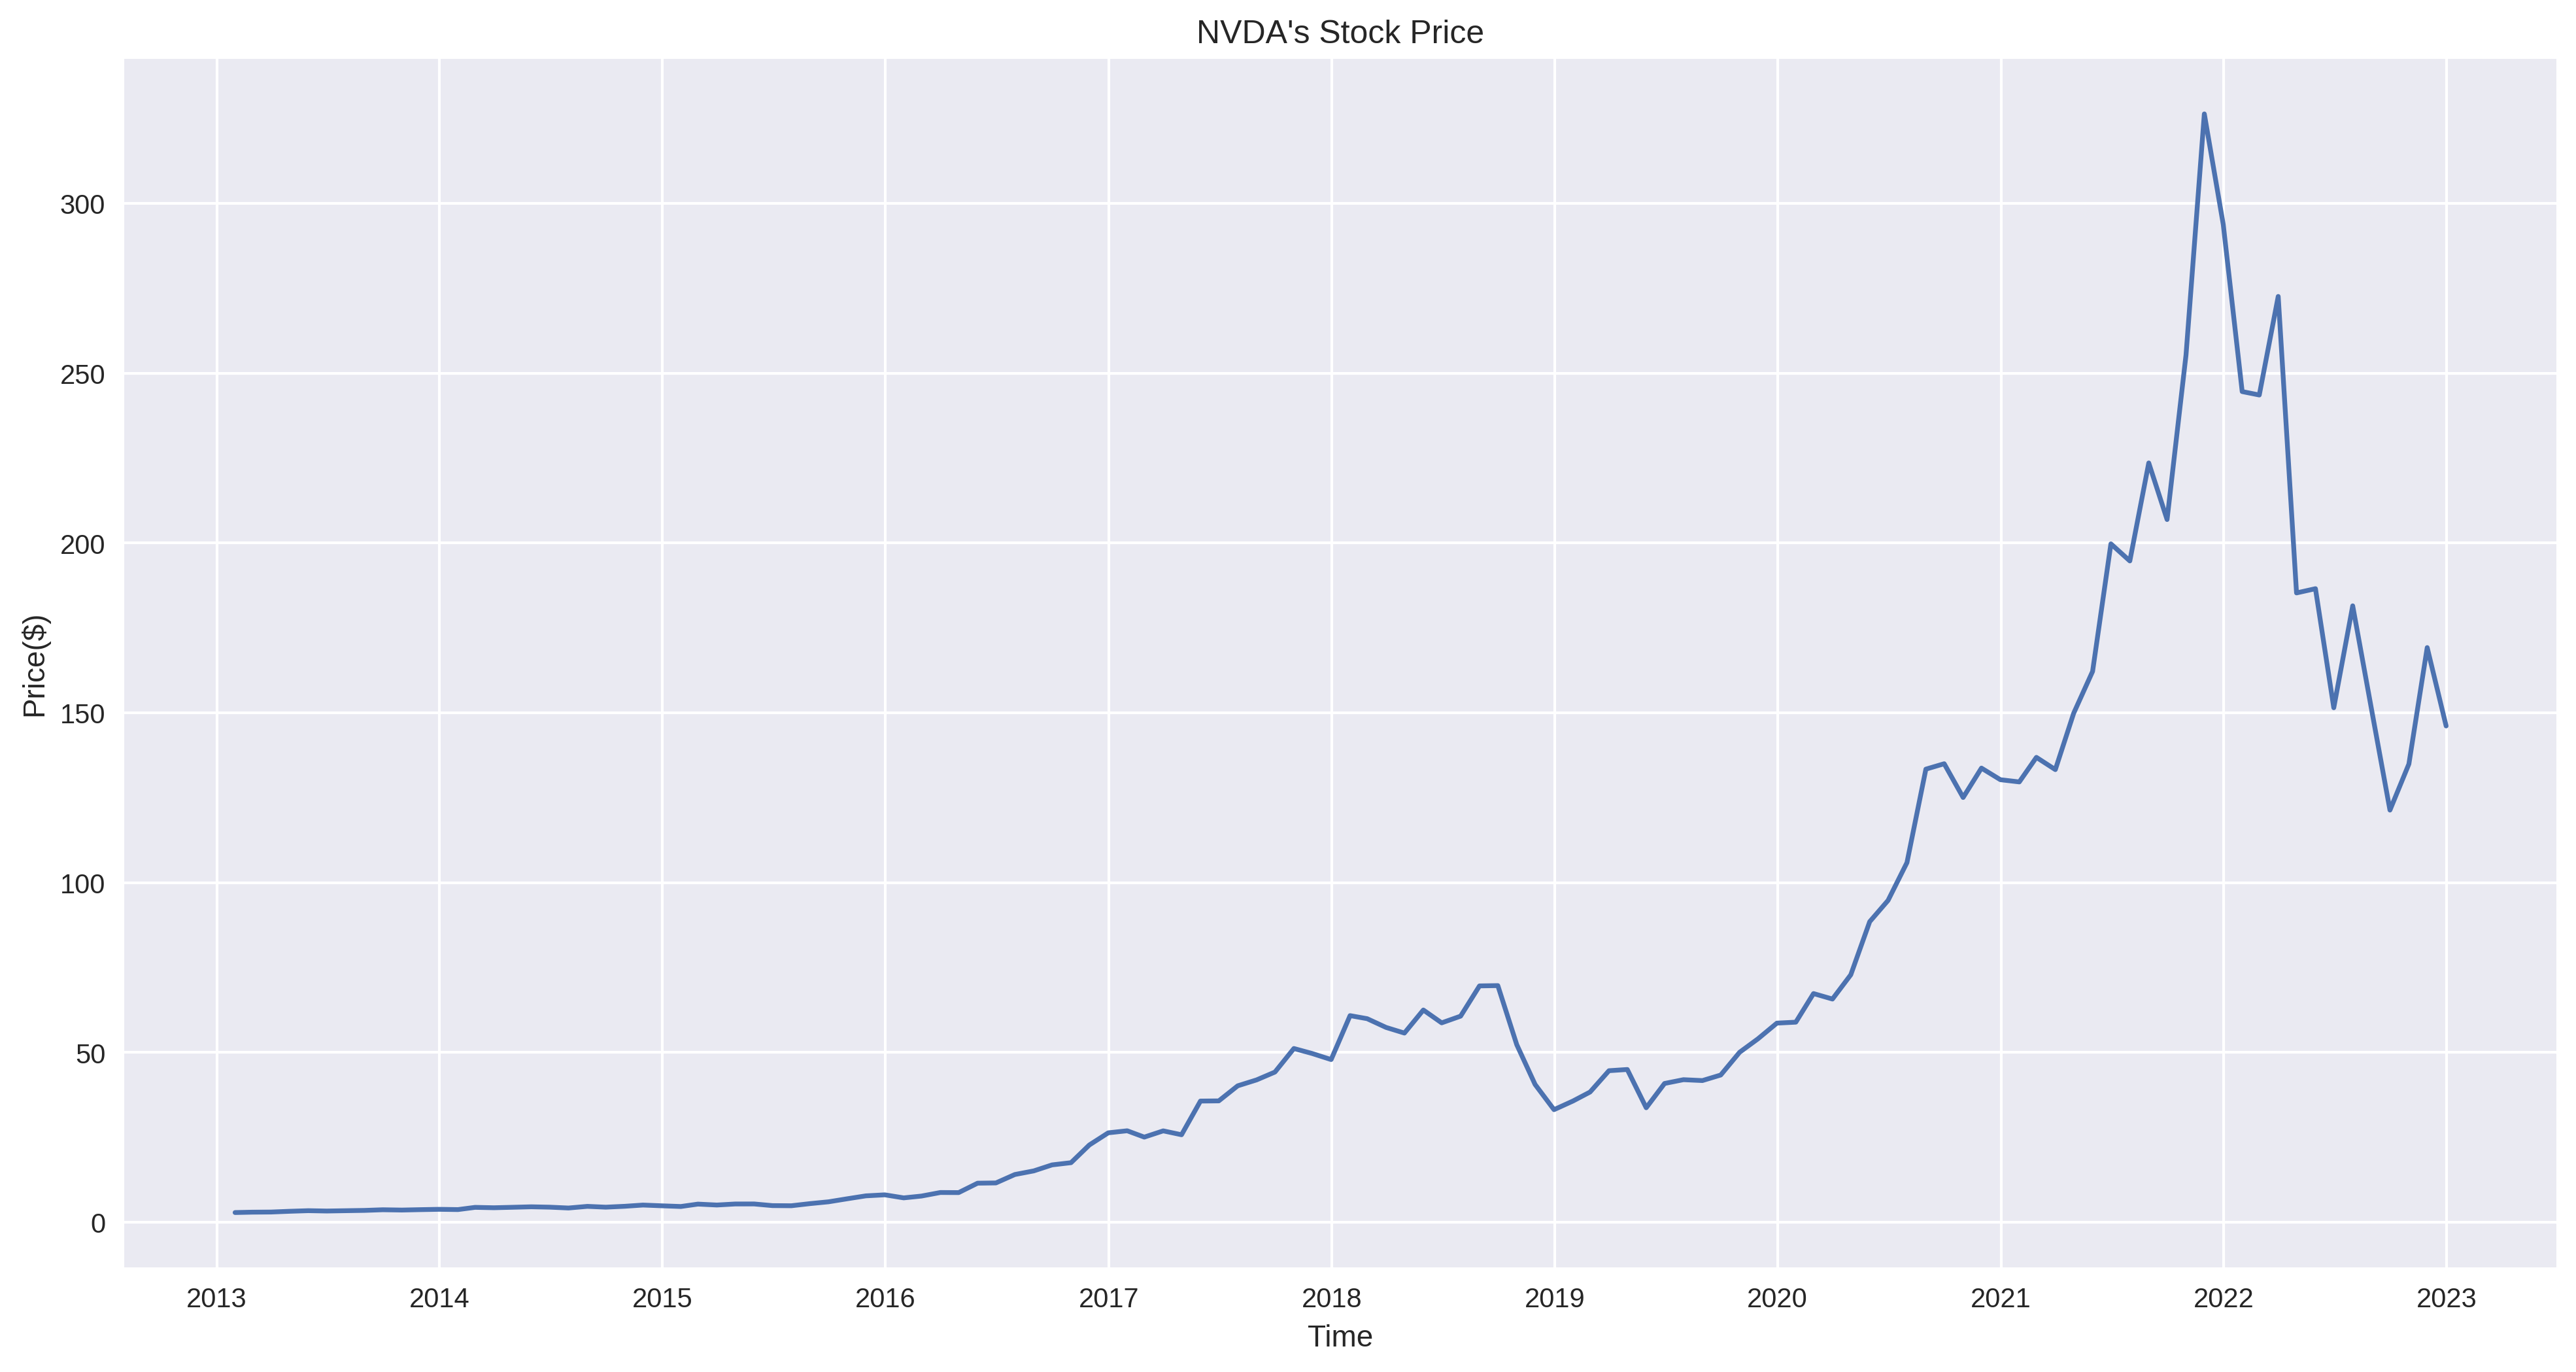

In [5]:
#visualize the monthly stock price of NVDA
plt.rcParams['figure.figsize'] = [16, 8]
fig, ax = plt.subplots()
ax.plot(data.index, prices)
ax.set(title=f"{stock}'s Stock Price", xlabel='Time', ylabel='Price($)');

In [6]:
#transform time series data into acceptable inputs of MLPs
def create_input_data(series, n_lags=1): #we use time t's stock price to forecast time t+1's value
  X, y=[], [] #create arrays of features and target variables
  for step in range(len(series)-n_lags):
    end_step = step + n_lags
    X.append(series[step:end_step])
    y.append(series[end_step])
  return np.array(X), np.array(y)

In [ ]:
#use the function and parameters we defined above
X, y=create_input_data(prices, n_lags)
#change numpy arrays to float(numerical) tensors
X_tensor=torch.from_numpy(X).float()
y_tensor=torch.from_numpy(y).float().unsqueeze(dim=1) #use unsqueeze to convert 1*n tensor to n*1 tensor

In [ ]:
#create training and validation datasets
#create the whole dataset to pytorch using TensorDataset
dataset=TensorDataset(X_tensor, y_tensor)
#create the splitting index
valid_index=len(X)-valid_size 
#split data use Subset()
train_dataset=Subset(dataset, list(range(valid_index)))
valid_dataset=Subset(dataset, list(range(valid_index, len(X))))
#create DataLoader
train_loader=DataLoader(dataset=train_dataset, batch_size=batch_size)
valid_loader=DataLoader(dataset=valid_dataset, batch_size=batch_size)

In [ ]:
#check the value in the first batch
next(iter(train_loader))[0]

tensor([[2.8303, 2.9406, 2.9800],
        [2.9406, 2.9800, 3.1984],
        [2.9800, 3.1984, 3.3780],
        [3.1984, 3.3780, 3.2777],
        [3.3780, 3.2777, 3.3710]])

In [ ]:
#perform a naive forecasting as benchmark, then evaluate the performance
naive_pred=prices[len(prices)-valid_size-1 : -1] #use last known samples as the forecast of next period
y_valid=prices[len(prices)-valid_size:]
#construct evaluate matrics
naive_mse=mean_squared_error(y_valid, naive_pred)
naive_rmse=np.sqrt(naive_mse)
#print the result
print(f"Naive Forecast Performance – MSE: {naive_mse:.2f}, RMSE: {naive_rmse:.2f}")

Naive Forecast Performance – MSE: 1393.20, RMSE: 37.33


In [ ]:
#define the MLP structure by nn.Module
class MLP(nn.Module):
  def __init__(self, input_size): #we store all the operations we want to carry out, without caring the execution order in this part
    super(MLP, self).__init__() #method that accepts parameters when create the instance of class
    self.linear1=nn.Linear(input_size, 8) #fully connected layers
    self.linear2=nn.Linear(8,4) #two hidden layers 
    self.linear3=nn.Linear(4,1)
    self.dropout=nn.Dropout(p=0.2) #avoid overfitting

  def forward(self, x): #this method uses x to denote the tensor of features with correct execution order
    x=self.linear1(x)
    x=F.relu(x)
    x=self.dropout(x) 
    x=self.linear2(x)
    x=F.relu(x) #activation function
    x=self.dropout(x)
    x=self.linear3(x)
    return x

In [ ]:
#define the seed, loss function, optimizer, model initialization
torch.manual_seed(42)
MLP=MLP(n_lags).to(device) #pass the model to the appropriate device
loss_function=nn.MSELoss()
optimizer=optim.Adam(MLP.parameters(), lr=0.001) #we need to specify which parameter we want to update and the value of learning rate

In [ ]:
#check the structure
MLP

MLP(
  (linear1): Linear(in_features=3, out_features=8, bias=True)
  (linear2): Linear(in_features=8, out_features=4, bias=True)
  (linear3): Linear(in_features=4, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
#model training
print_every=20
train_losses, valid_losses=[],[]

for epoch in range(n_epochs):
  #initialization
  running_loss_train = 0
  running_loss_valid = 0

  #for training period and evaluation period, some layers such as Dropout or Batch Normalization act differently
  MLP.train()

  for x_batch, y_batch in train_loader: #iterate over DataLoader by reciving one batch each time

    optimizer.zero_grad() #set gradients of all optimized torch.Tensors to 0 at the beginning
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    y_hat = MLP(x_batch) #obtain the predictions
    loss = loss_function(y_batch, y_hat)
    loss.backward() #to calculate the gradient used for backpropagation
    optimizer.step() #update the weights, to carry out one step of optimization routine
    running_loss_train += loss.item()*x_batch.size(0) #transform to overall training loss
  epoch_loss_train=running_loss_train / len(train_loader.dataset) #we store the average loss of batches as training loss for each epoch
  train_losses.append(epoch_loss_train)

  with torch.no_grad(): #disabled gradient descent, without updating weights and BP this part, reducing memory storage and computing costs
    MLP.eval() #performance evaluation on validaton set

    for x_valid, y_valid in valid_loader:
      x_valid=x_valid.to(device)
      y_valid=y_valid.to(device)
      y_hat=MLP(x_valid)
      loss=loss_function(y_valid, y_hat)
      running_loss_valid += loss.item()*x_valid.size(0)
    epoch_loss_valid = running_loss_valid / len(valid_loader.dataset)

    if epoch>0 and epoch_loss_valid < min(valid_losses):
      best_epoch = epoch
      torch.save(MLP.state_dict(), './mlp.pth') #.state_dict(), accessing to model's parameter and weight, and the path of storage

    valid_losses.append(epoch_loss_valid)
  
  if epoch % print_every==0:
    print(f"<{epoch}> – Train. loss: {epoch_loss_train:.2f} \t Valid. loss: {epoch_loss_valid:.2f}")
print(f'Lowest loss recorded in epoch: {best_epoch}')

<0> – Train. loss: 8118.58 	 Valid. loss: 42964.25
<20> – Train. loss: 966.87 	 Valid. loss: 1414.64
<40> – Train. loss: 752.89 	 Valid. loss: 1166.75
<60> – Train. loss: 753.48 	 Valid. loss: 986.32
<80> – Train. loss: 1989.15 	 Valid. loss: 1382.08
<100> – Train. loss: 1424.33 	 Valid. loss: 1362.64
<120> – Train. loss: 1678.09 	 Valid. loss: 1073.65
<140> – Train. loss: 1067.09 	 Valid. loss: 1407.13
<160> – Train. loss: 1120.34 	 Valid. loss: 940.54
<180> – Train. loss: 652.82 	 Valid. loss: 1101.03
<200> – Train. loss: 1304.05 	 Valid. loss: 950.89
<220> – Train. loss: 1002.20 	 Valid. loss: 1128.80
<240> – Train. loss: 382.00 	 Valid. loss: 1004.15
<260> – Train. loss: 1273.10 	 Valid. loss: 1190.60
<280> – Train. loss: 614.00 	 Valid. loss: 866.27
<300> – Train. loss: 859.73 	 Valid. loss: 790.40
<320> – Train. loss: 966.59 	 Valid. loss: 991.63
<340> – Train. loss: 790.78 	 Valid. loss: 792.88
<360> – Train. loss: 777.02 	 Valid. loss: 1142.51
<380> – Train. loss: 1052.36 	 Val

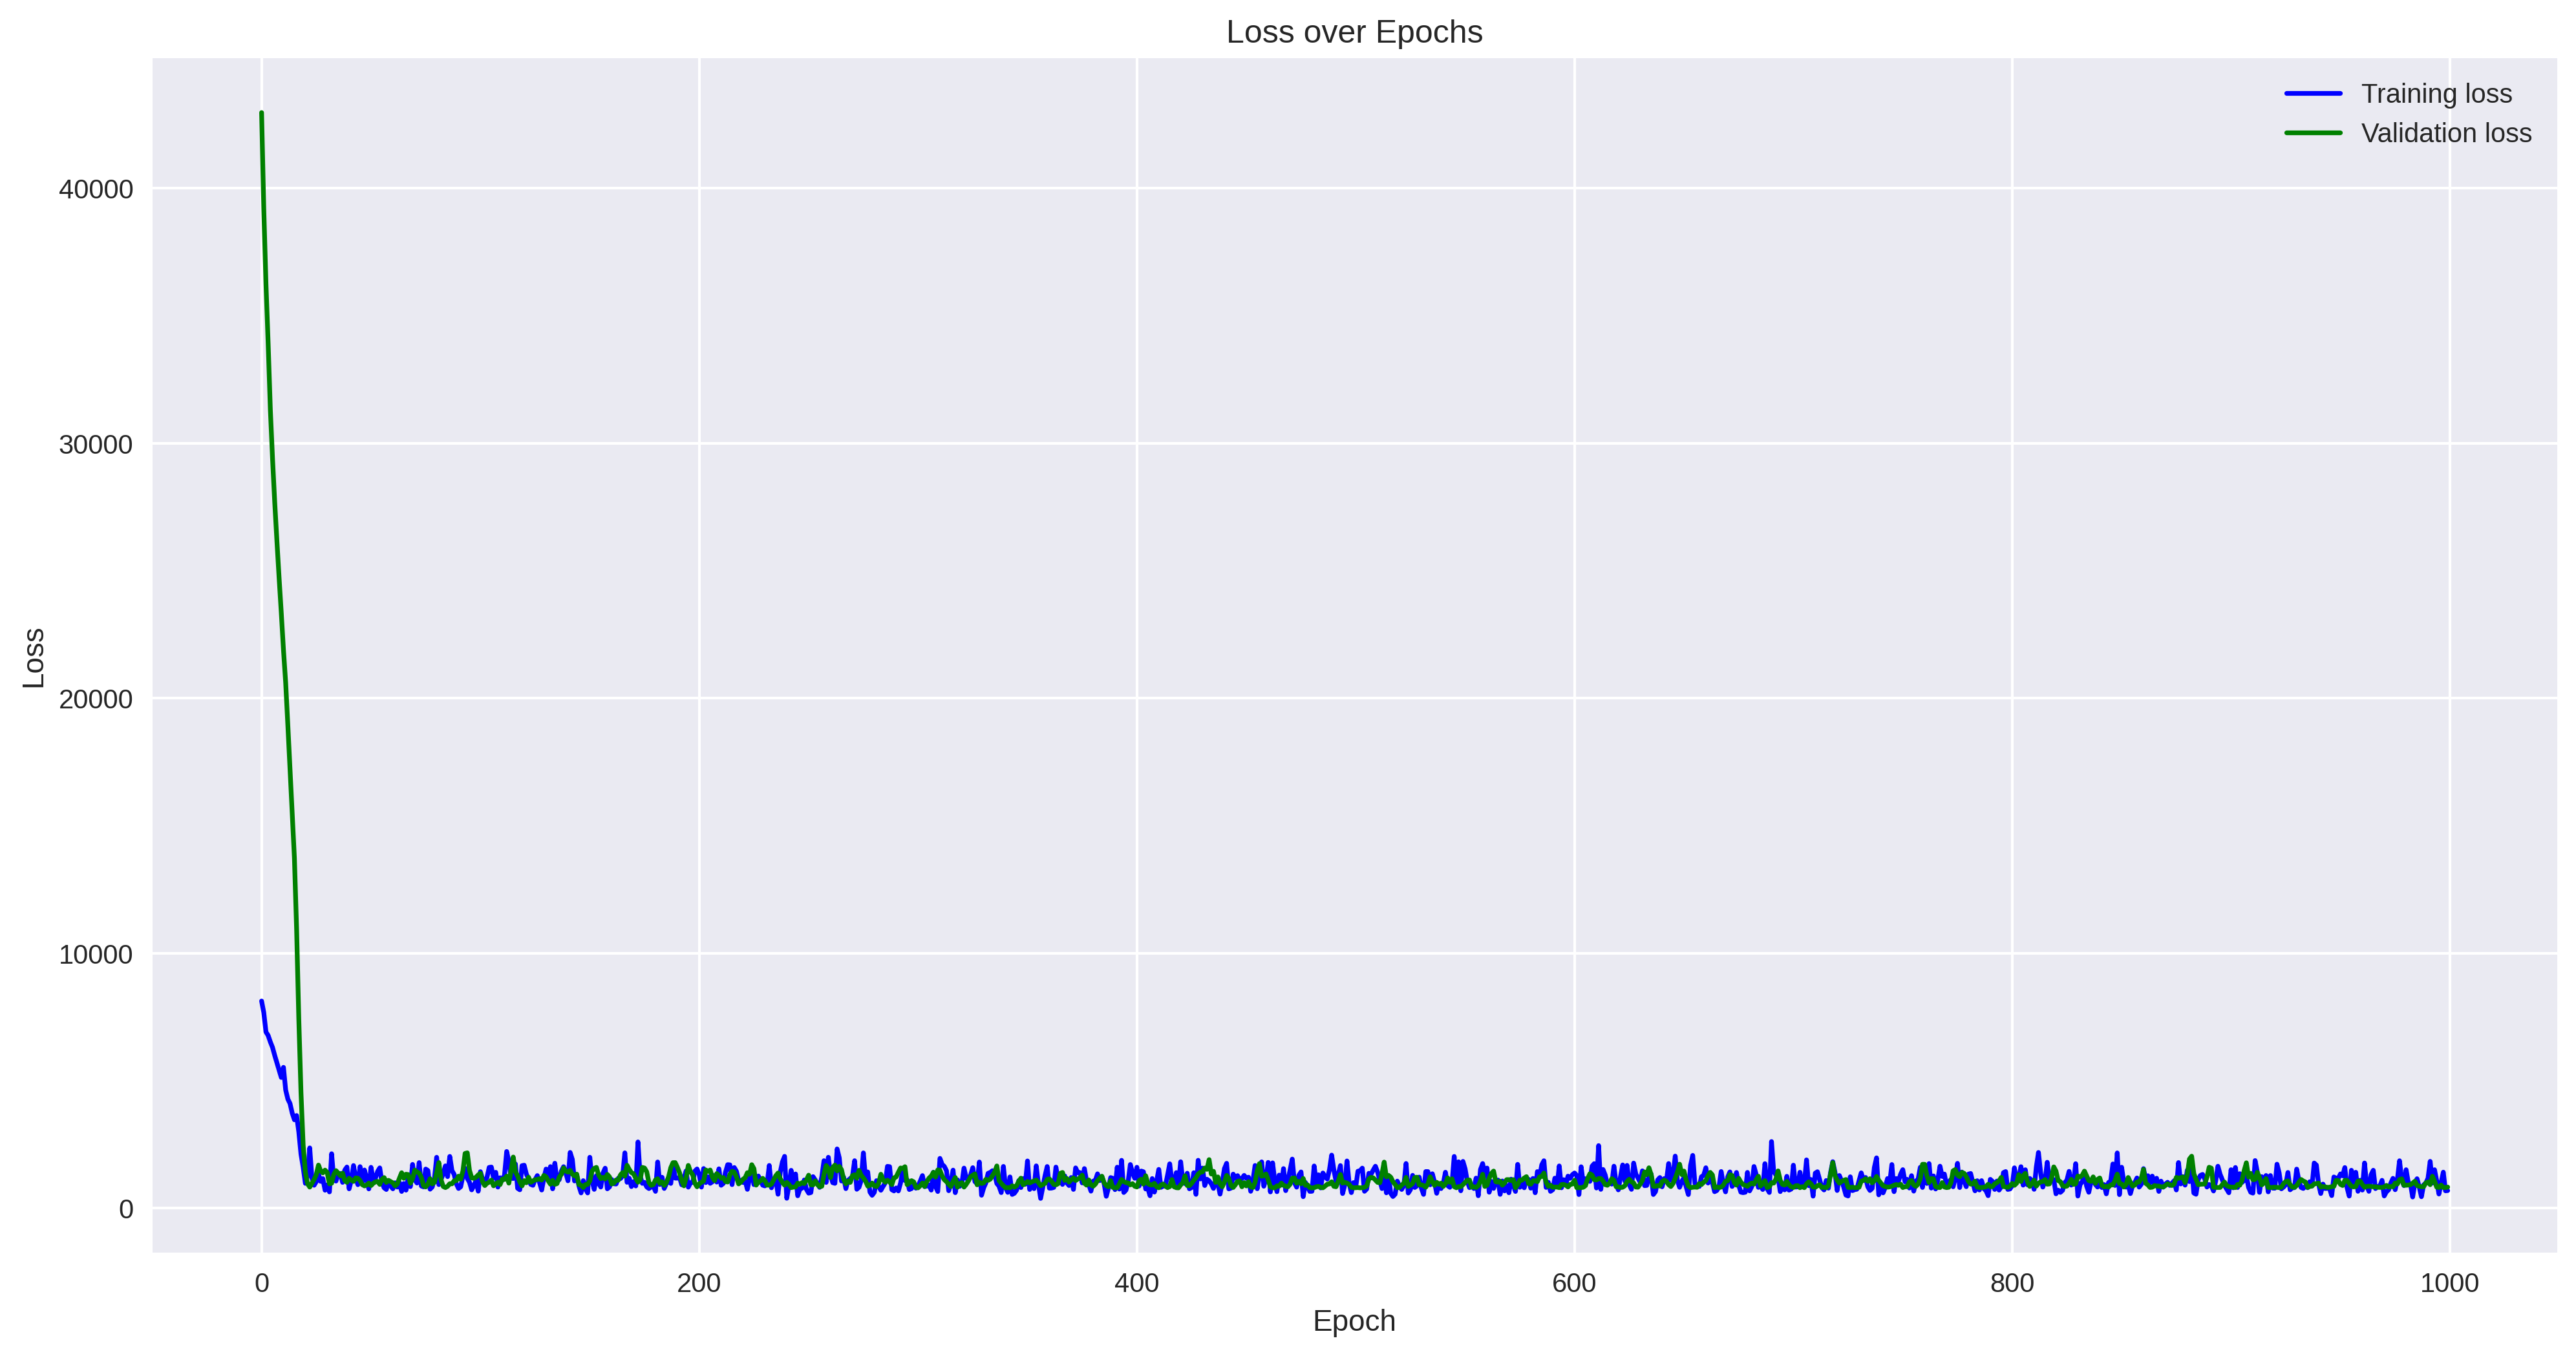

In [ ]:
#plot the losses per epoch
train_losses=np.array(train_losses)
valid_losses=np.array(valid_losses)
plt.rcParams['figure.figsize'] = [16, 8]
fig, ax = plt.subplots()
ax.plot(train_losses, color='blue', label='Training loss')
ax.plot(valid_losses, color='green', label='Validation loss')
ax.set(title="Loss over Epochs", xlabel='Epoch', ylabel='Loss')
ax.legend()

In [ ]:
#make predictions
y_pred, y_valid=[], []
with torch.no_grad():
  MLP.eval()
  for x_val, y_val in valid_loader:
    x_valid = x_val.to(device) 
    y_pred.append(MLP(x_valid))
    y_valid.append(y_val)
y_pred=torch.cat(y_pred).numpy().flatten() #concatenate a list of tensors, convert tensor to numpy array, use flatten() to obtain 1D array
y_valid=torch.cat(y_valid).numpy().flatten()

MLP's Forecast – MSE: 820.05, RMSE: 28.64


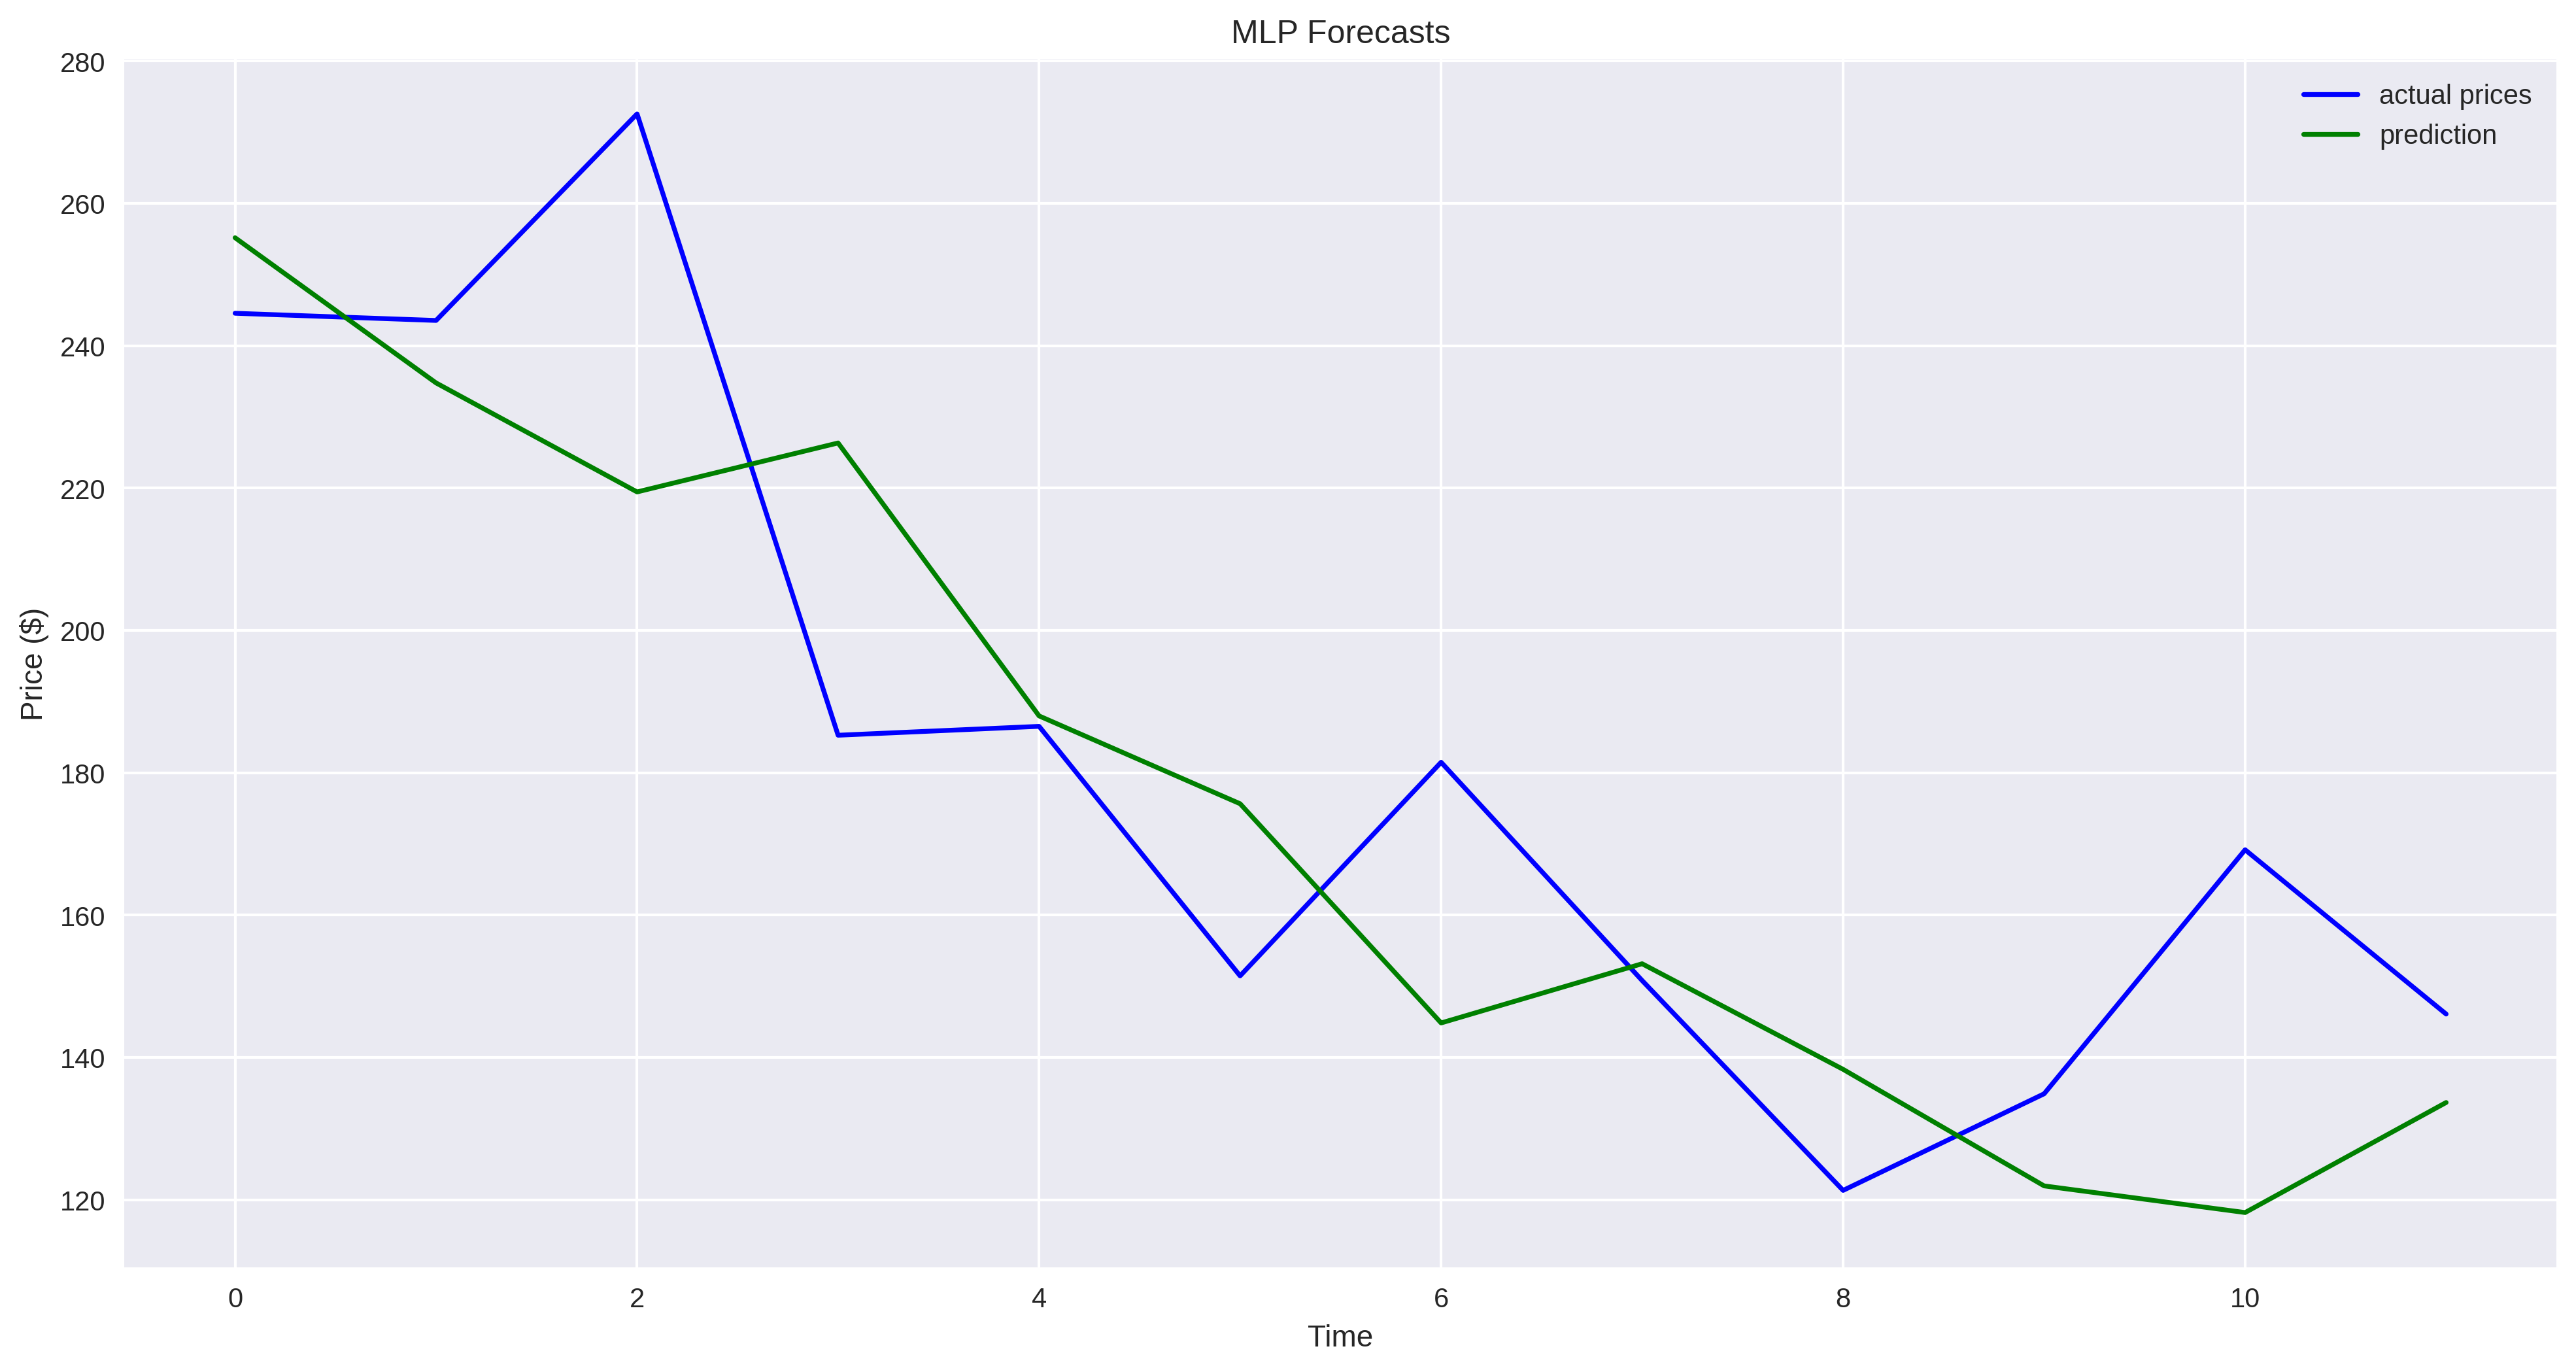

In [ ]:
#predictions evaluation and visualization
mlp_mse = mean_squared_error(y_valid, y_pred)
mlp_rmse = np.sqrt(mlp_mse)
print(f"MLP's Forecast – MSE: {mlp_mse:.2f}, RMSE: {mlp_rmse:.2f}")
plt.rcParams['figure.figsize'] = [16, 8]
fig, ax = plt.subplots()
ax.plot(y_valid, color='blue', label='actual prices')
ax.plot(y_pred, color='green', label='prediction')
ax.set(title="MLP Forecasts", xlabel='Time', ylabel='Price ($)')
ax.legend()

### Other Tuning Tricks:
- Different batch size, number of epochs, learning rate
- Different number of hidden layers, activation functions
- number of lagged period
- Normalize or standardize the data

In [ ]:
#use Sequential approach to define MLP with unique order marks, quiet similar to Keras 
Model=nn.Sequential(
    nn.Linear(3,8),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(8,4),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(4,1)
)
Model

Sequential(
  (0): Linear(in_features=3, out_features=8, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=8, out_features=4, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=4, out_features=1, bias=True)
)

- We can use `OrderDict` to provide customed <u>unique name</u> for each layer 

In [ ]:
#use sklearn package for MLP forecasting
#https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html
from sklearn.neural_network import MLPRegressor
mlp=MLPRegressor( #another we can use MLPClassifier(...)
    hidden_layer_sizes=(8, 4, ),
    learning_rate='constant',
    batch_size=5,
    max_iter=1000,
    random_state=42)

In [ ]:
#data split
valid_i=len(X)-valid_size
X_train = X[:valid_i, ]
y_train = y[:valid_i]
X_valid = X[valid_i:, ]
y_valid = y[valid_i:]

In [ ]:
#model training
mlp.fit(X_train, y_train)

MLPRegressor(batch_size=5, hidden_layer_sizes=(8, 4), max_iter=1000,
             random_state=42)

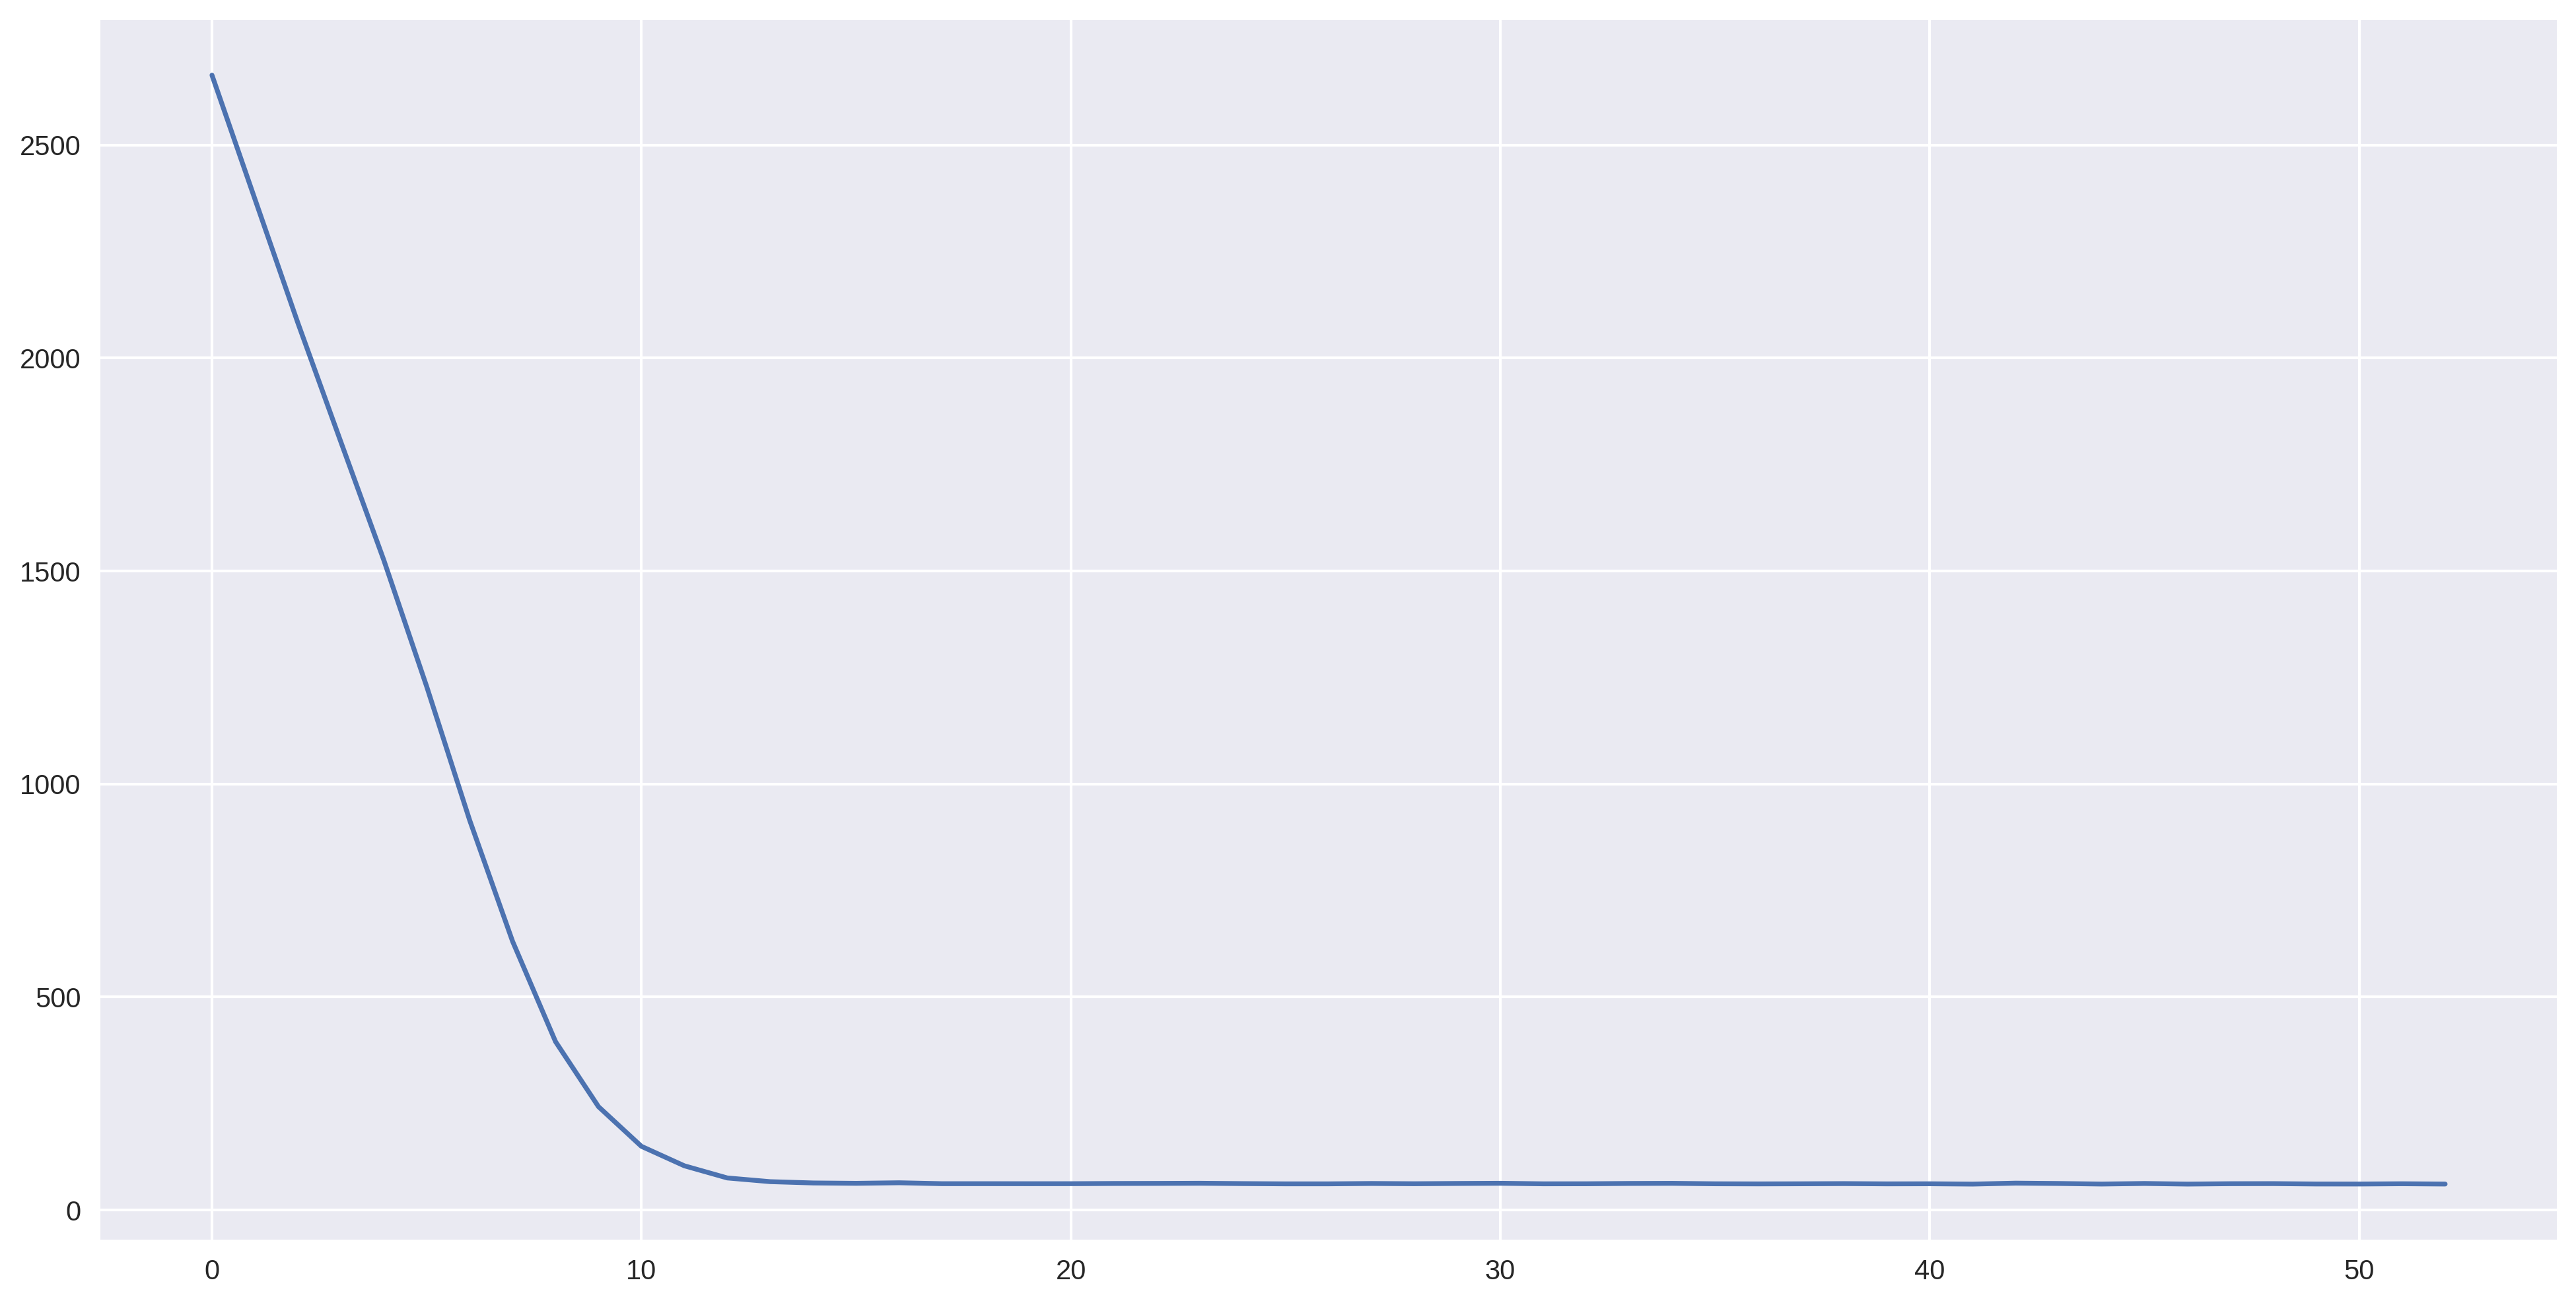

In [ ]:
#loss over epoch visualizations
plt.rcParams['figure.figsize'] = [16, 8]
plt.plot(mlp.loss_curve_)

In [ ]:
#get the predictions
y_pred = mlp.predict(X_valid)

Scikit-Learn MLP's forecast - MSE: 4438.38, RMSE: 66.62


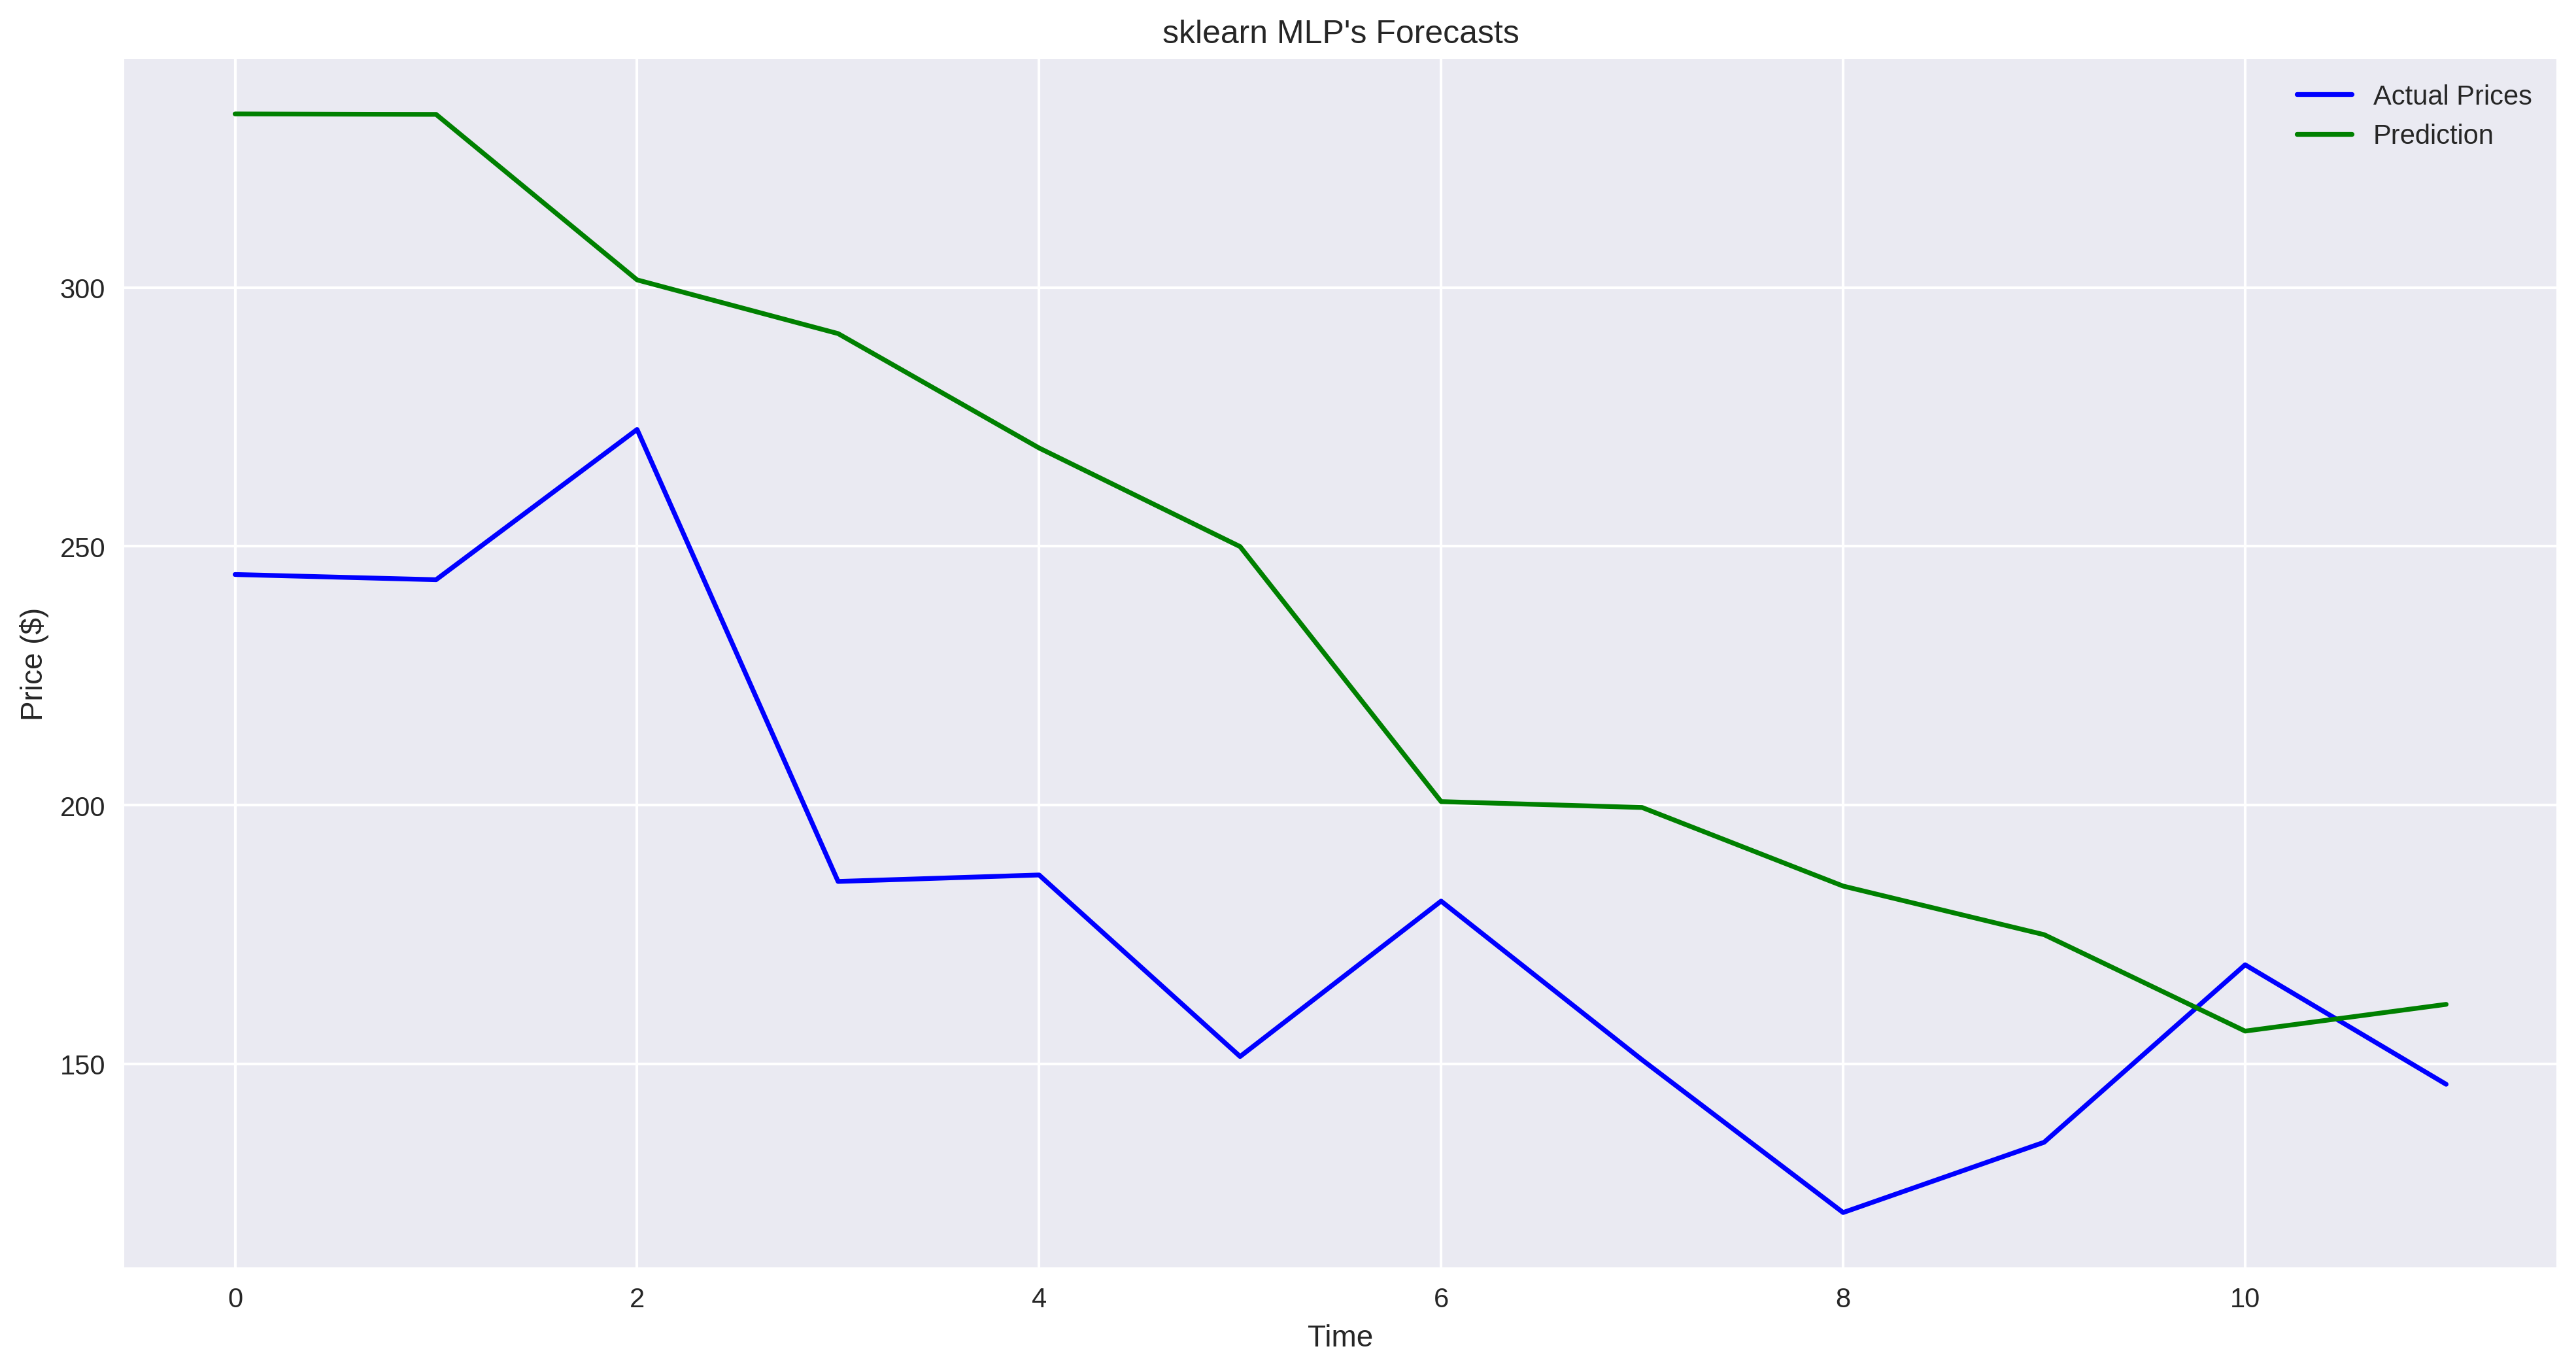

In [ ]:
#performance evaluation and prediction result visualization
sklearn_mlp_mse = mean_squared_error(y_valid, y_pred)
sklearn_mlp_rmse = np.sqrt(sklearn_mlp_mse)
print(f"Scikit-Learn MLP's forecast - MSE: {sklearn_mlp_mse:.2f}, RMSE: {sklearn_mlp_rmse:.2f}")

plt.rcParams['figure.figsize'] = [16, 8]
fig, ax = plt.subplots()
ax.plot(y_valid, color='blue', label='Actual Prices')
ax.plot(y_pred, color='green', label='Prediction')
ax.set(title="sklearn MLP's Forecasts", xlabel='Time', ylabel='Price ($)')
ax.legend()

In [ ]:
#multi-period forecasting
#use MLP to forecast more than one unit period ahead
#convert into dataset that acceptable for MLP
def create_input_dataset(series, n_lags=1, n_leads=1):
  X, y=[], []
  for step in range(len(series)-n_lags-n_leads+1):
    end_step=step+n_lags
    forward_end=end_step+n_leads
    X.append(series[step:end_step])
    y.append(series[end_step:forward_end])
  return np.array(X), np.array(y)

In [ ]:
#create features and target
n_lags=3
n_leads=2
X, y = create_input_dataset(prices, n_lags, n_leads)
X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).float()

In [ ]:
#train and validation dataset creation
dataset = TensorDataset(X_tensor, y_tensor)

valid_index = len(X) - valid_size + (n_leads - 1)
train_dataset = Subset(dataset, list(range(valid_index)))
valid_dataset = Subset(dataset, list(range(valid_index, len(X))))

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size)

In [ ]:
#define MLP for multi-period forecasting
class MLP(nn.Module):
  def __init__(self, input_size, output_size):
    super(MLP, self).__init__()
    self.linear1 = nn.Linear(input_size, 16)
    self.linear2 = nn.Linear(16, 8)
    self.linear3 = nn.Linear(8, output_size)
    self.dropout = nn.Dropout(p=0.2)
    
  def forward(self, x): #with correct execution order
    x = self.linear1(x)
    x = F.relu(x)
    x = self.dropout(x)
    x = self.linear2(x)
    x = F.relu(x)
    x = self.dropout(x)
    x = self.linear3(x)
    return x 

In [ ]:
#set seed, pass parameters to the model, set loss function and optimizer
torch.manual_seed(42)
model = MLP(n_lags, n_leads).to(device) 
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
PRINT_EVERY = 20
train_losses, valid_losses = [], []

for epoch in range(n_epochs):
  running_loss_train = 0
  running_loss_valid = 0

  model.train()
    
  for x_batch, y_batch in train_loader:
    optimizer.zero_grad()
        
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    y_hat = model(x_batch)
    loss = loss_function(y_batch, y_hat)
    loss.backward()
    optimizer.step()
    running_loss_train += loss.item() * x_batch.size(0)
        
  epoch_loss_train = running_loss_train / len(train_loader.dataset)
  train_losses.append(epoch_loss_train)

  with torch.no_grad():
    model.eval()
        
    for x_val, y_val in valid_loader:
      x_val = x_val.to(device)
      y_val = y_val.to(device)
      y_hat = model(x_val)
      loss = loss_function(y_val, y_hat)
      running_loss_valid += loss.item() * x_val.size(0)
            
    epoch_loss_valid = running_loss_valid / len(valid_loader.dataset)
            
    if epoch > 0 and epoch_loss_valid < min(valid_losses):
      best_epoch = epoch
      torch.save(model.state_dict(), './mlp_multiperiod.pth')
            
    valid_losses.append(epoch_loss_valid)

  if epoch % PRINT_EVERY == 0:
    print(f"<{epoch}> - Train. loss: {epoch_loss_train:.2f} \t Valid. loss: {epoch_loss_valid:.2f}")
print(f'Lowest loss recorded in epoch: {best_epoch}')

<0> - Train. loss: 8348.46 	 Valid. loss: 39069.51
<20> - Train. loss: 2199.30 	 Valid. loss: 2109.44
<40> - Train. loss: 916.20 	 Valid. loss: 1972.29
<60> - Train. loss: 754.17 	 Valid. loss: 1766.40
<80> - Train. loss: 1200.14 	 Valid. loss: 3205.25
<100> - Train. loss: 998.36 	 Valid. loss: 2048.10
<120> - Train. loss: 1000.63 	 Valid. loss: 3155.46
<140> - Train. loss: 1086.35 	 Valid. loss: 2484.98
<160> - Train. loss: 499.69 	 Valid. loss: 2702.75
<180> - Train. loss: 733.89 	 Valid. loss: 1801.61
<200> - Train. loss: 819.01 	 Valid. loss: 1845.35
<220> - Train. loss: 1653.59 	 Valid. loss: 3770.18
<240> - Train. loss: 777.97 	 Valid. loss: 2241.91
<260> - Train. loss: 1176.60 	 Valid. loss: 4339.01
<280> - Train. loss: 935.38 	 Valid. loss: 2369.08
<300> - Train. loss: 812.15 	 Valid. loss: 2061.37
<320> - Train. loss: 627.01 	 Valid. loss: 3594.06
<340> - Train. loss: 761.14 	 Valid. loss: 2929.46
<360> - Train. loss: 1169.01 	 Valid. loss: 1652.35
<380> - Train. loss: 900.74 

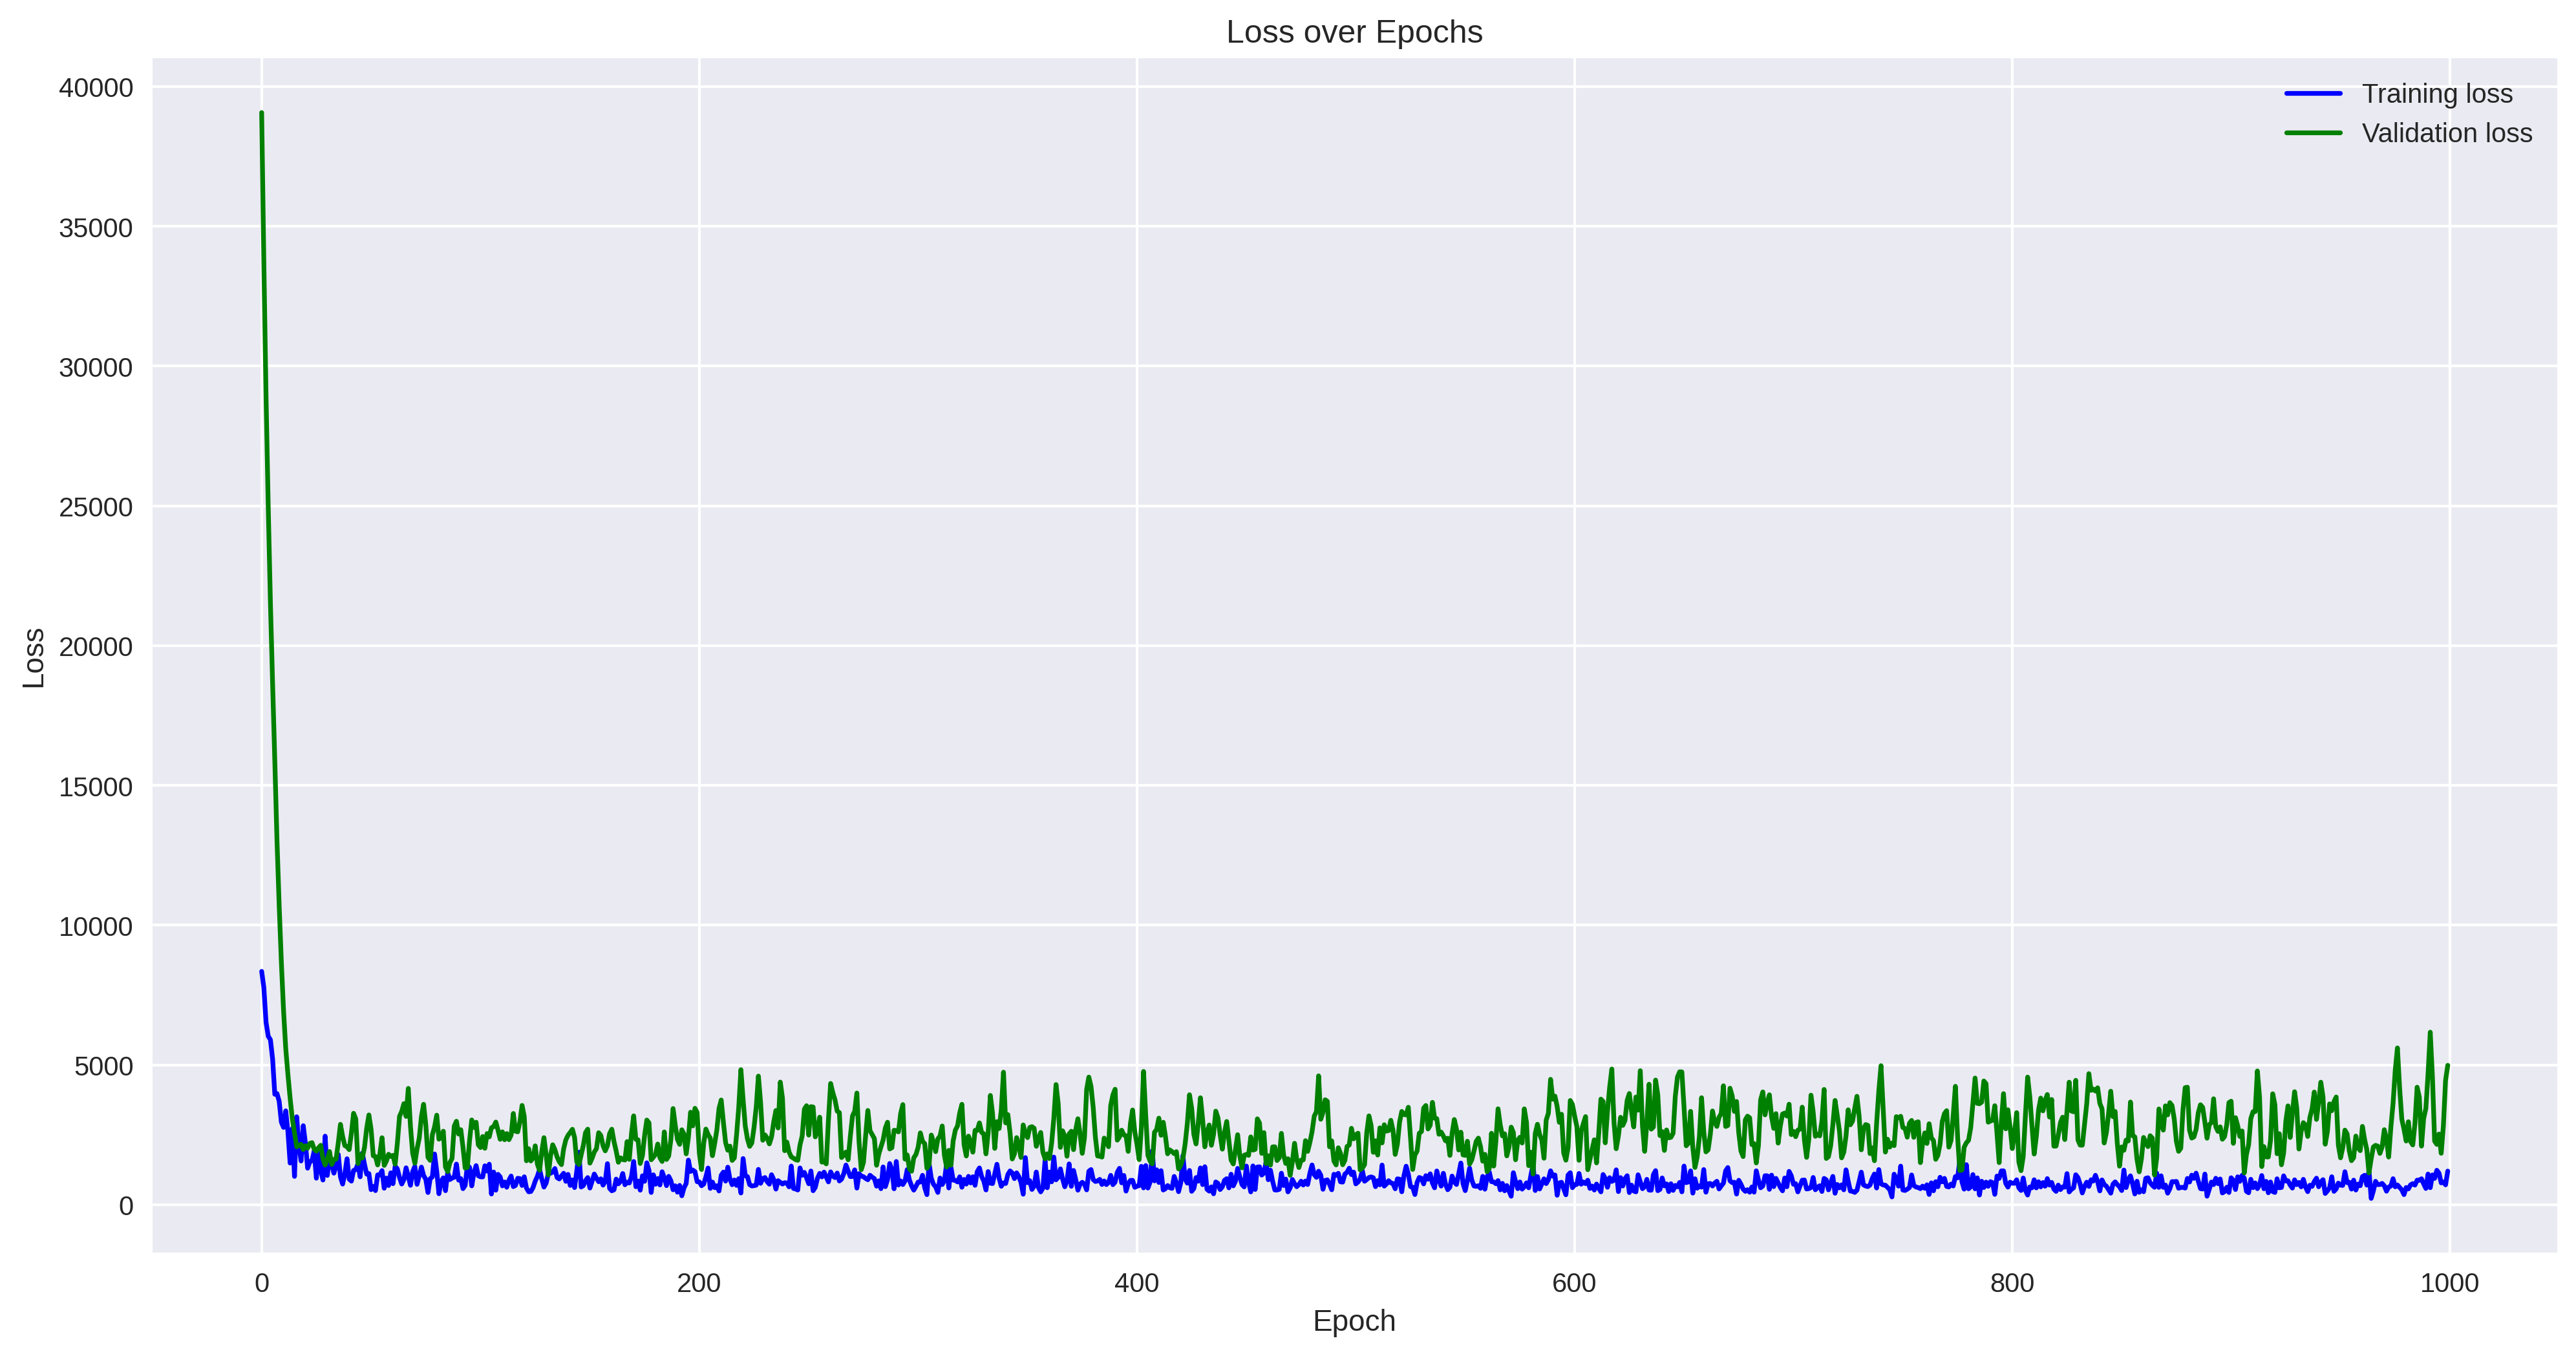

In [ ]:
#plot the train and valid losses over epochs
plt.rcParams['figure.figsize'] = [16, 8]
train_losses = np.array(train_losses)
valid_losses = np.array(valid_losses)

fig, ax = plt.subplots()
ax.plot(train_losses, color='blue', label='Training loss')
ax.plot(valid_losses, color='green', label='Validation loss')
ax.set(title="Loss over Epochs", xlabel='Epoch', ylabel='Loss')
ax.legend()

In [ ]:
#make predictions
y_pred = []
with torch.no_grad():
  model.eval()
  for x_val, y_val in valid_loader:
    x_val = x_val.to(device)
    yhat = model(x_val)
    y_pred.append(yhat)
y_pred = torch.cat(y_pred).numpy()

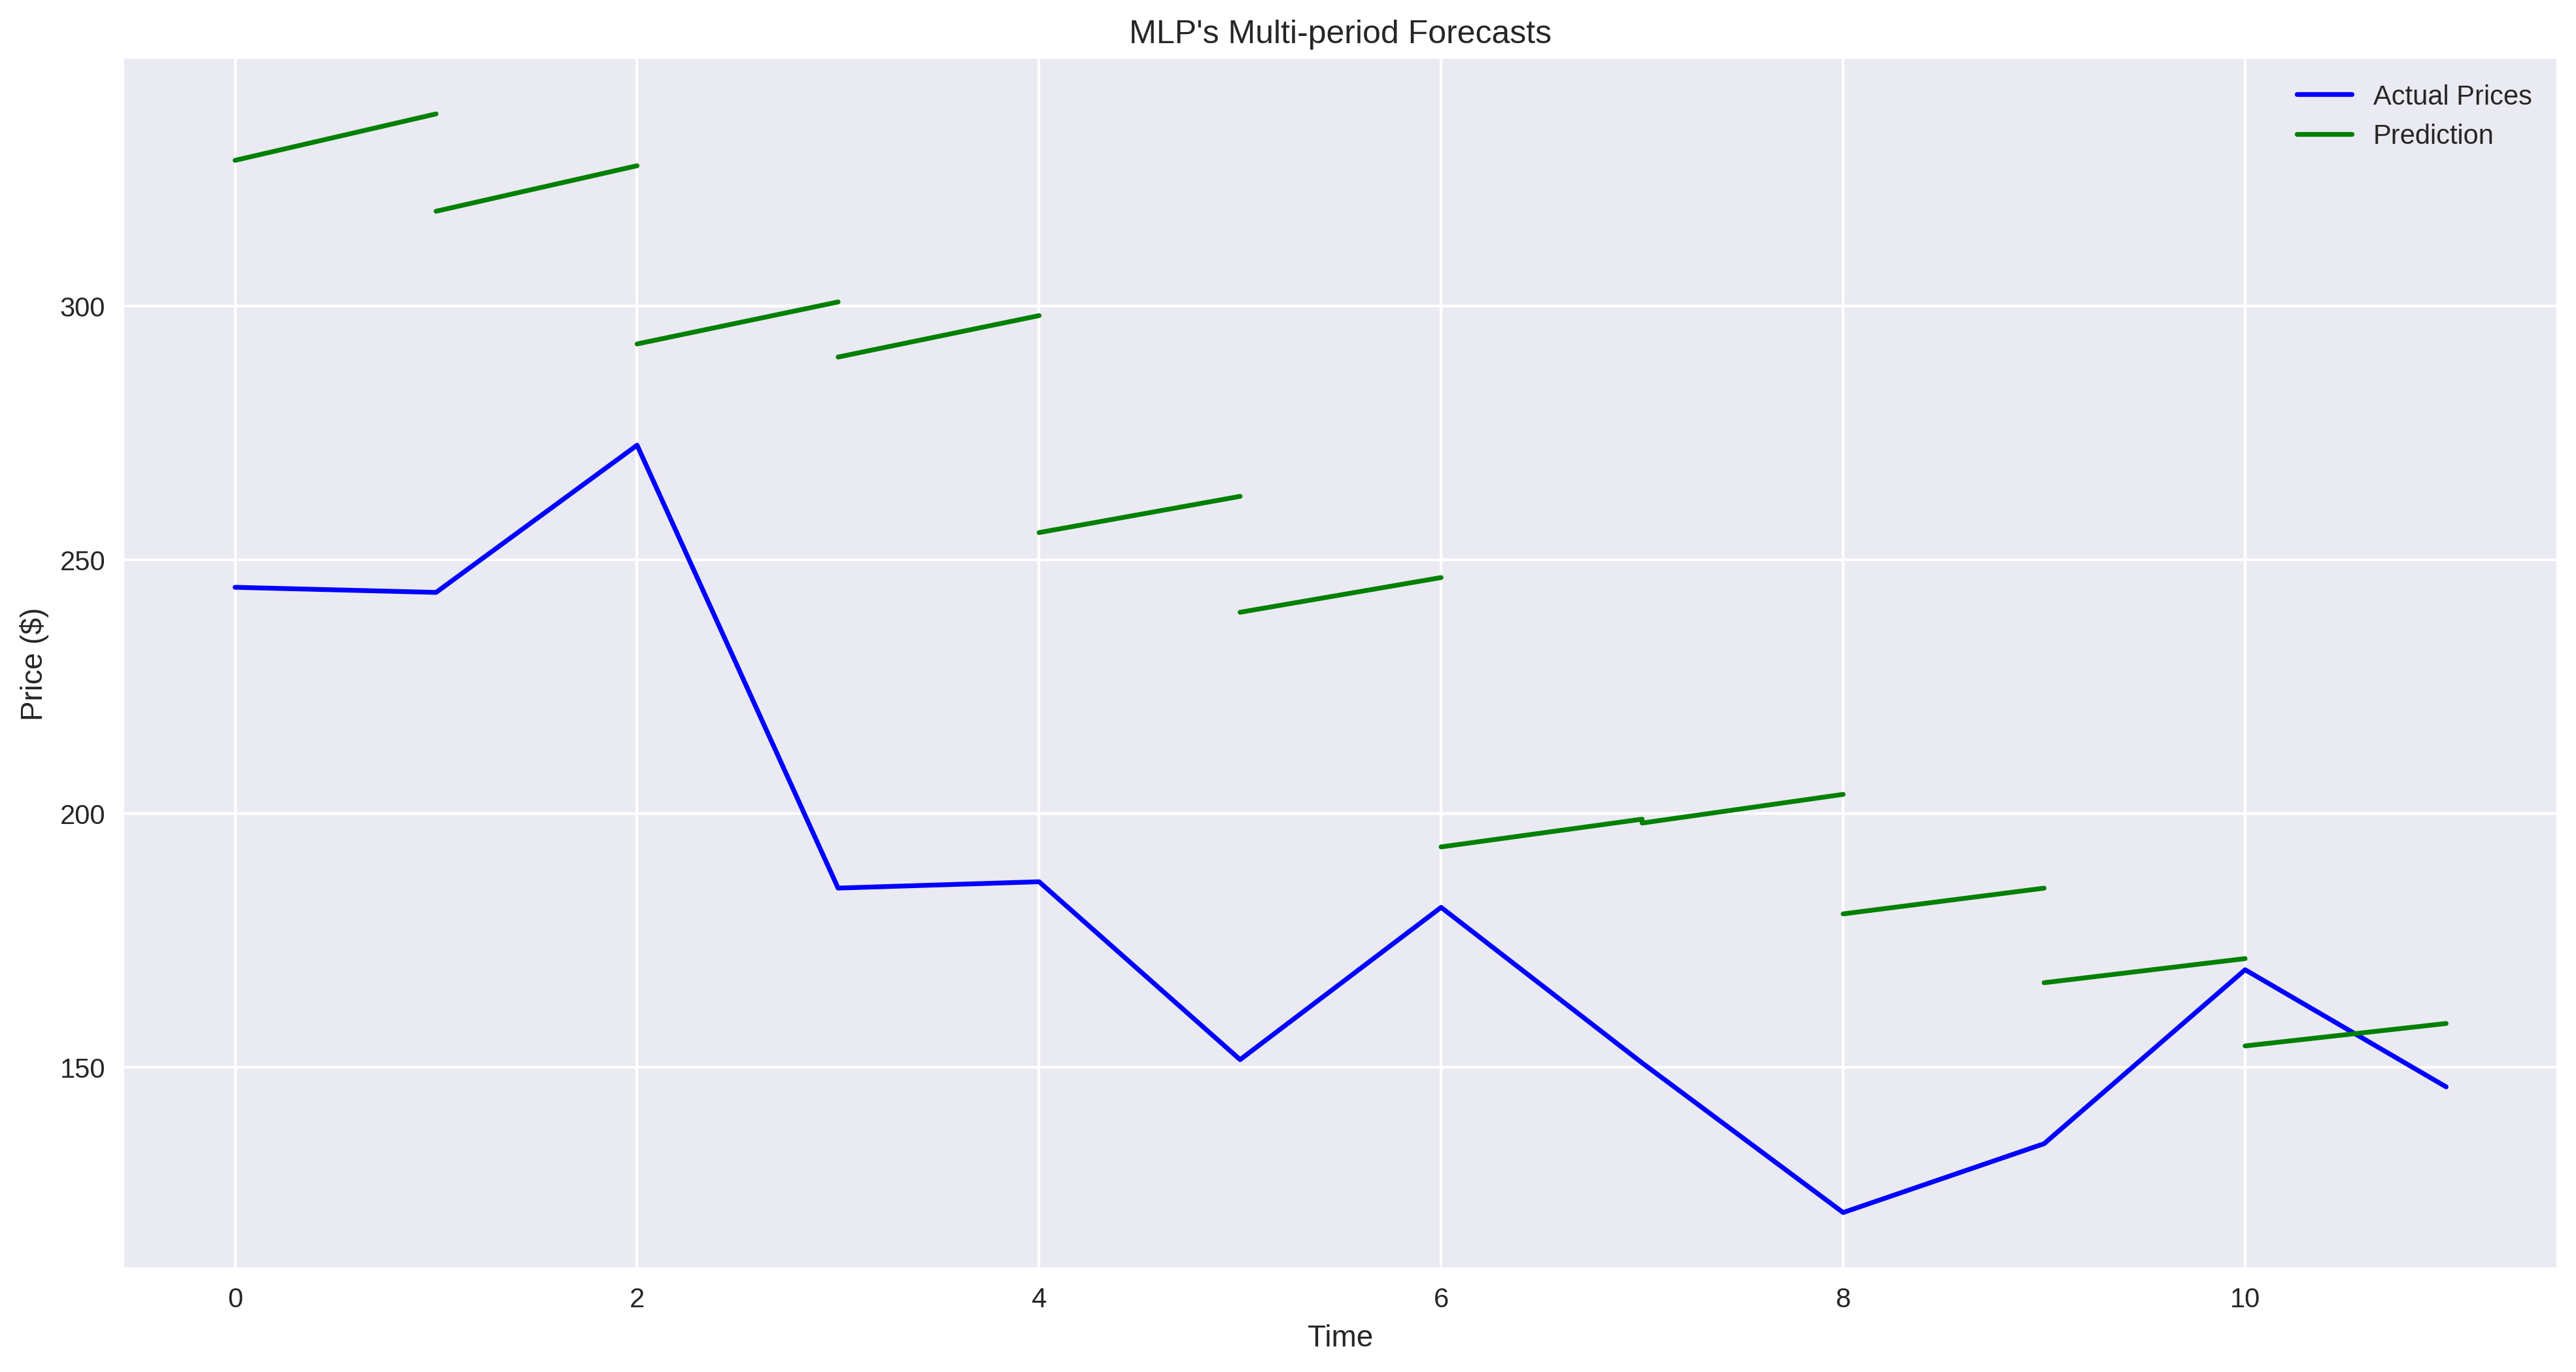

In [ ]:
plt.rcParams['figure.figsize'] = [16, 8]
fig, ax = plt.subplots()
ax.plot(y_valid, color='blue', label='Actual Prices')
#since we set n_leads=2, forecasting t+1 and t+2 two timing points
for i in range(len(y_pred)):
  if i == 0:
    ax.plot(np.array([i, i+1]), y_pred[i], color='green', label='Prediction')
  else:
    ax.plot(np.array([i, i+1]), y_pred[i], color='green')
ax.set(title="MLP's Multi-period Forecasts", xlabel='Time', ylabel='Price ($)')
ax.legend()
plt.show()

## CNN for Time Series Forecasting
- Architecture:
  - Convolutional layer: convolutional filtering extract potential features
  - Pooling layer: reduce the size of image or series to preserve important features 
  - Fully connected layer: located at the end of network, mapping the extracted features to values or classes.
  - Output layer
- Other Modern CNN Structures:
  - VGG-16/19, AlexNet, ResNet, GoogleNet

### Benefits of Using 1D CNN for Time Series Forecasting:
- Effective for finding fixed-length segments' features
- noise-resistent
- Computationally cheaper than RNN and perform better sometimes
- 1D networks allow for larger filter sizes
- Remove the need for domain knowledge for manual feature creation
- Be able to extract informative features

In [7]:
#get the dataset
stock='NVDA'
startdate='2018-01-01'
enddate='2022-12-31'
valid_start='2022-07-01'
n_lags=12 #we use past 12 months' weekly data to predict next week's close price level
batch_size=10
n_epochs=2000

In [8]:
NVDA = yf.download(stock, startdate, enddate, progress=False).resample('W-MON').last()
valid_size = NVDA.loc[valid_start:enddate].shape[0]
prices=NVDA['Adj Close'].values

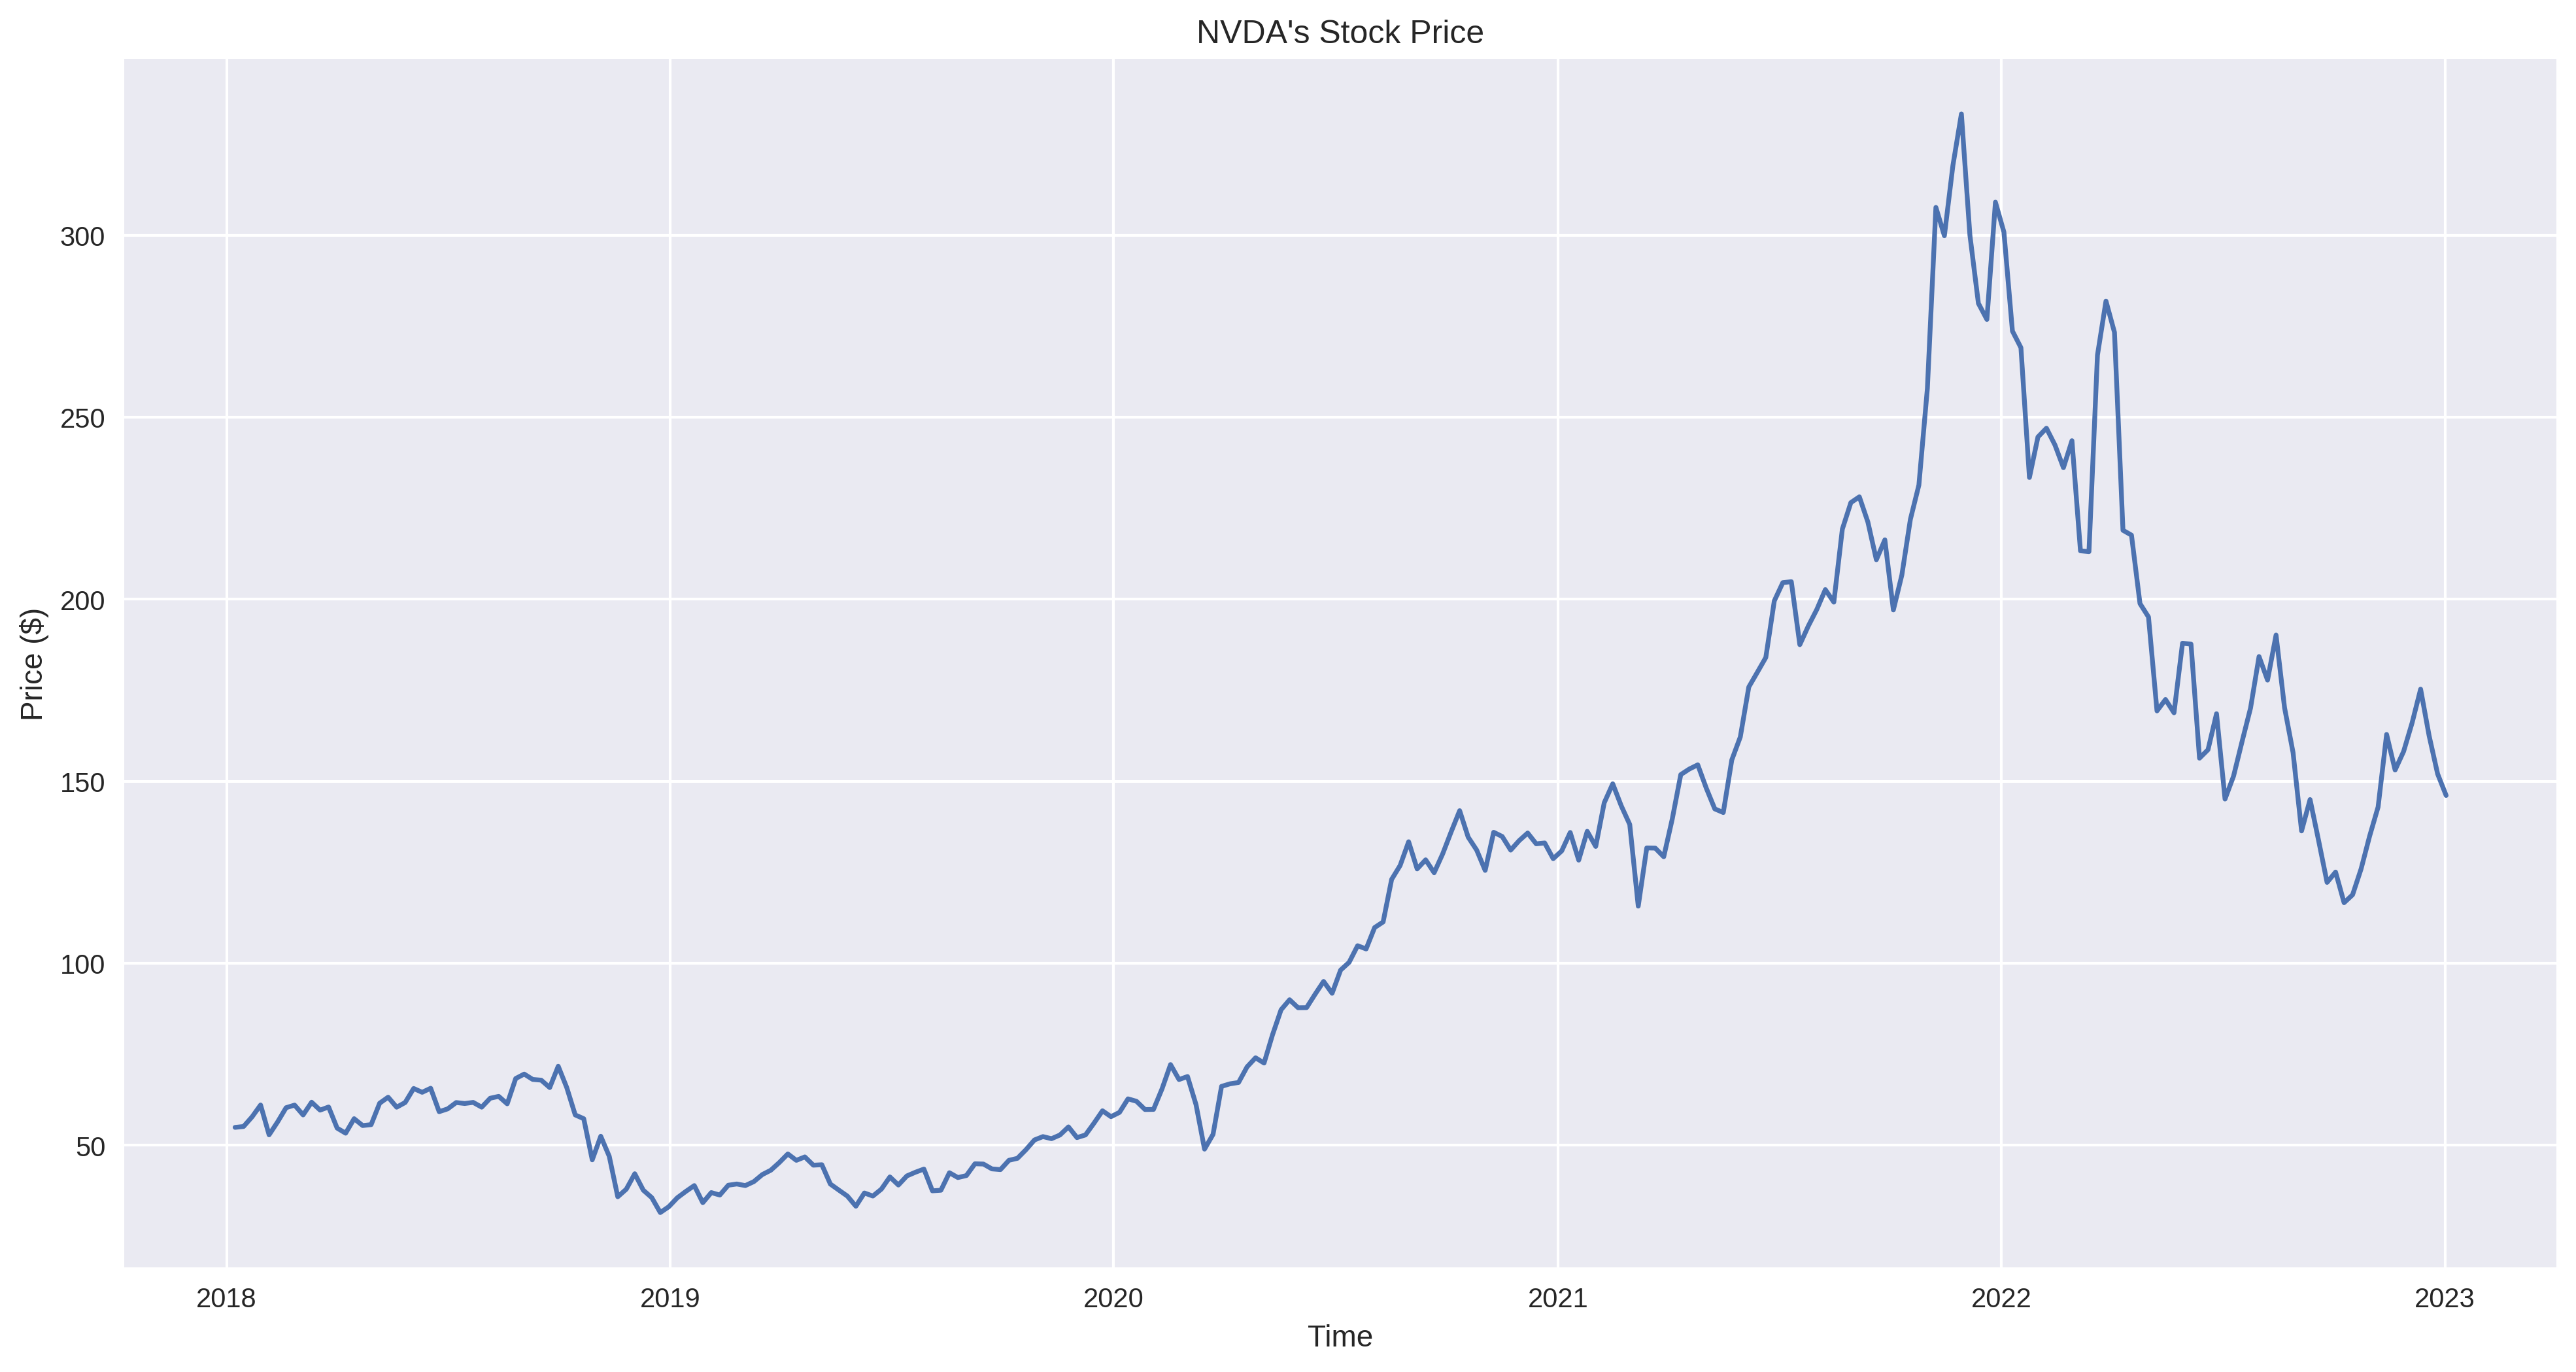

In [9]:
fig, ax = plt.subplots()
ax.plot(NVDA.index, prices)
ax.set(title=f"{stock}'s Stock Price", xlabel='Time', ylabel='Price ($)');

In [10]:
import random
import os

def create_input_data(series, n_lags=1, n_leads=1):
  X, y = [], []
  for step in range(len(series) - n_lags - n_leads + 1):
    end_step = step + n_lags
    forward_end = end_step + n_leads
    X.append(series[step:end_step])
    y.append(series[end_step:forward_end])
  return np.array(X), np.array(y)

# custom function for reproducibility
def custom_set_seed(seed):
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  np.random.seed(seed)
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)

In [11]:
#transform time series data to the input of CNN model
X, y = create_input_data(prices, n_lags)

In [12]:
custom_set_seed(42)

valid_ind = len(X) - valid_size
X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).float().unsqueeze(dim=1)

dataset = TensorDataset(X_tensor, y_tensor)

train_dataset = Subset(dataset, list(range(valid_ind)))
valid_dataset = Subset(dataset, list(range(valid_ind, len(X))))

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size)

In [24]:
from collections import OrderedDict
class Flatten(nn.Module):
  def forward(self, x):
    return x.view(x.size()[0], -1)

CNN = nn.Sequential(OrderedDict([('conv_1', nn.Conv1d(1, 32, 3, padding=1)), # [no. of batches, channels, length of series], add padding means here doesn't reduce size of input series
                                 #padding adds extra elements at beginning and end of series, "zero","same", or defined width
                                 ('max_pool_1', nn.MaxPool1d(2)), #kernel size=2, pooling reduce length of series
                                 ('relu_1', nn.ReLU()),
                                 ('flatten', Flatten()),
                                 ('fc_1', nn.Linear(192, 50)),
                                 ('relu_2', nn.ReLU()),
                                 ('dropout_1', nn.Dropout(0.4)),
                                 ('fc_2', nn.Linear(50, 1))]))
print(CNN)

Sequential(
  (conv_1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (max_pool_1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu_1): ReLU()
  (flatten): Flatten()
  (fc_1): Linear(in_features=192, out_features=50, bias=True)
  (relu_2): ReLU()
  (dropout_1): Dropout(p=0.4, inplace=False)
  (fc_2): Linear(in_features=50, out_features=1, bias=True)
)


In [25]:
CNN = CNN.to(device)
loss_function = nn.MSELoss()
optimizer = optim.SGD(CNN.parameters(), lr=0.0001)

In [26]:
PRINT_EVERY = 100
train_losses, valid_losses = [], []

for epoch in range(n_epochs):
  running_loss_train = 0
  running_loss_valid = 0

  CNN.train()
    
  for x_batch, y_batch in train_loader:
    optimizer.zero_grad()
    x_batch = x_batch.to(device)
    x_batch = x_batch.view(x_batch.shape[0], 1, n_lags)
    y_batch = y_batch.to(device)
    y_batch = y_batch.view(y_batch.shape[0], 1, 1)
    y_hat = CNN(x_batch).view(y_batch.shape[0], 1, 1)
    loss = torch.sqrt(loss_function(y_batch, y_hat))
    loss.backward()
    optimizer.step()
    running_loss_train += loss.item() * x_batch.size(0)
        
  epoch_loss_train = running_loss_train / len(train_loader.dataset)
  train_losses.append(epoch_loss_train)

  with torch.no_grad():
    CNN.eval()
    for x_val, y_val in valid_loader:
      x_val = x_val.to(device)
      x_val = x_val.view(x_val.shape[0], 1, n_lags)
      y_val = y_val.to(device)
      y_val = y_val.view(y_val.shape[0], 1, 1)
      y_hat = CNN(x_val).view(y_val.shape[0], 1, 1)
      loss = torch.sqrt(loss_function(y_val, y_hat))
      running_loss_valid += loss.item() * x_val.size(0)
            
    epoch_loss_valid = running_loss_valid / len(valid_loader.dataset)
    if epoch > 0 and epoch_loss_valid < min(valid_losses):
      best_epoch = epoch
      torch.save(CNN.state_dict(), './cnn.pth')
    valid_losses.append(epoch_loss_valid)

  if epoch % PRINT_EVERY == 0:
    print(f"<{epoch}> - Train. loss: {epoch_loss_train:.6f} \t Valid. loss: {epoch_loss_valid:.6f}")
        
print(f'Lowest loss recorded in epoch: {best_epoch}')

<0> - Train. loss: 44.974549 	 Valid. loss: 61.337914
<100> - Train. loss: 25.614356 	 Valid. loss: 14.584457
<200> - Train. loss: 25.399266 	 Valid. loss: 19.429643
<300> - Train. loss: 19.875750 	 Valid. loss: 11.621471
<400> - Train. loss: 23.633683 	 Valid. loss: 20.080819
<500> - Train. loss: 22.450733 	 Valid. loss: 14.904553
<600> - Train. loss: 20.975502 	 Valid. loss: 18.467008
<700> - Train. loss: 19.656514 	 Valid. loss: 11.825982
<800> - Train. loss: 18.566041 	 Valid. loss: 13.438065
<900> - Train. loss: 20.138846 	 Valid. loss: 11.694958
<1000> - Train. loss: 21.589491 	 Valid. loss: 15.447075
<1100> - Train. loss: 18.288979 	 Valid. loss: 12.051815
<1200> - Train. loss: 20.238927 	 Valid. loss: 14.734744
<1300> - Train. loss: 20.580369 	 Valid. loss: 12.848201
<1400> - Train. loss: 19.185611 	 Valid. loss: 13.023794
<1500> - Train. loss: 21.064697 	 Valid. loss: 14.400165
<1600> - Train. loss: 21.305515 	 Valid. loss: 11.206841
<1700> - Train. loss: 21.099298 	 Valid. lo

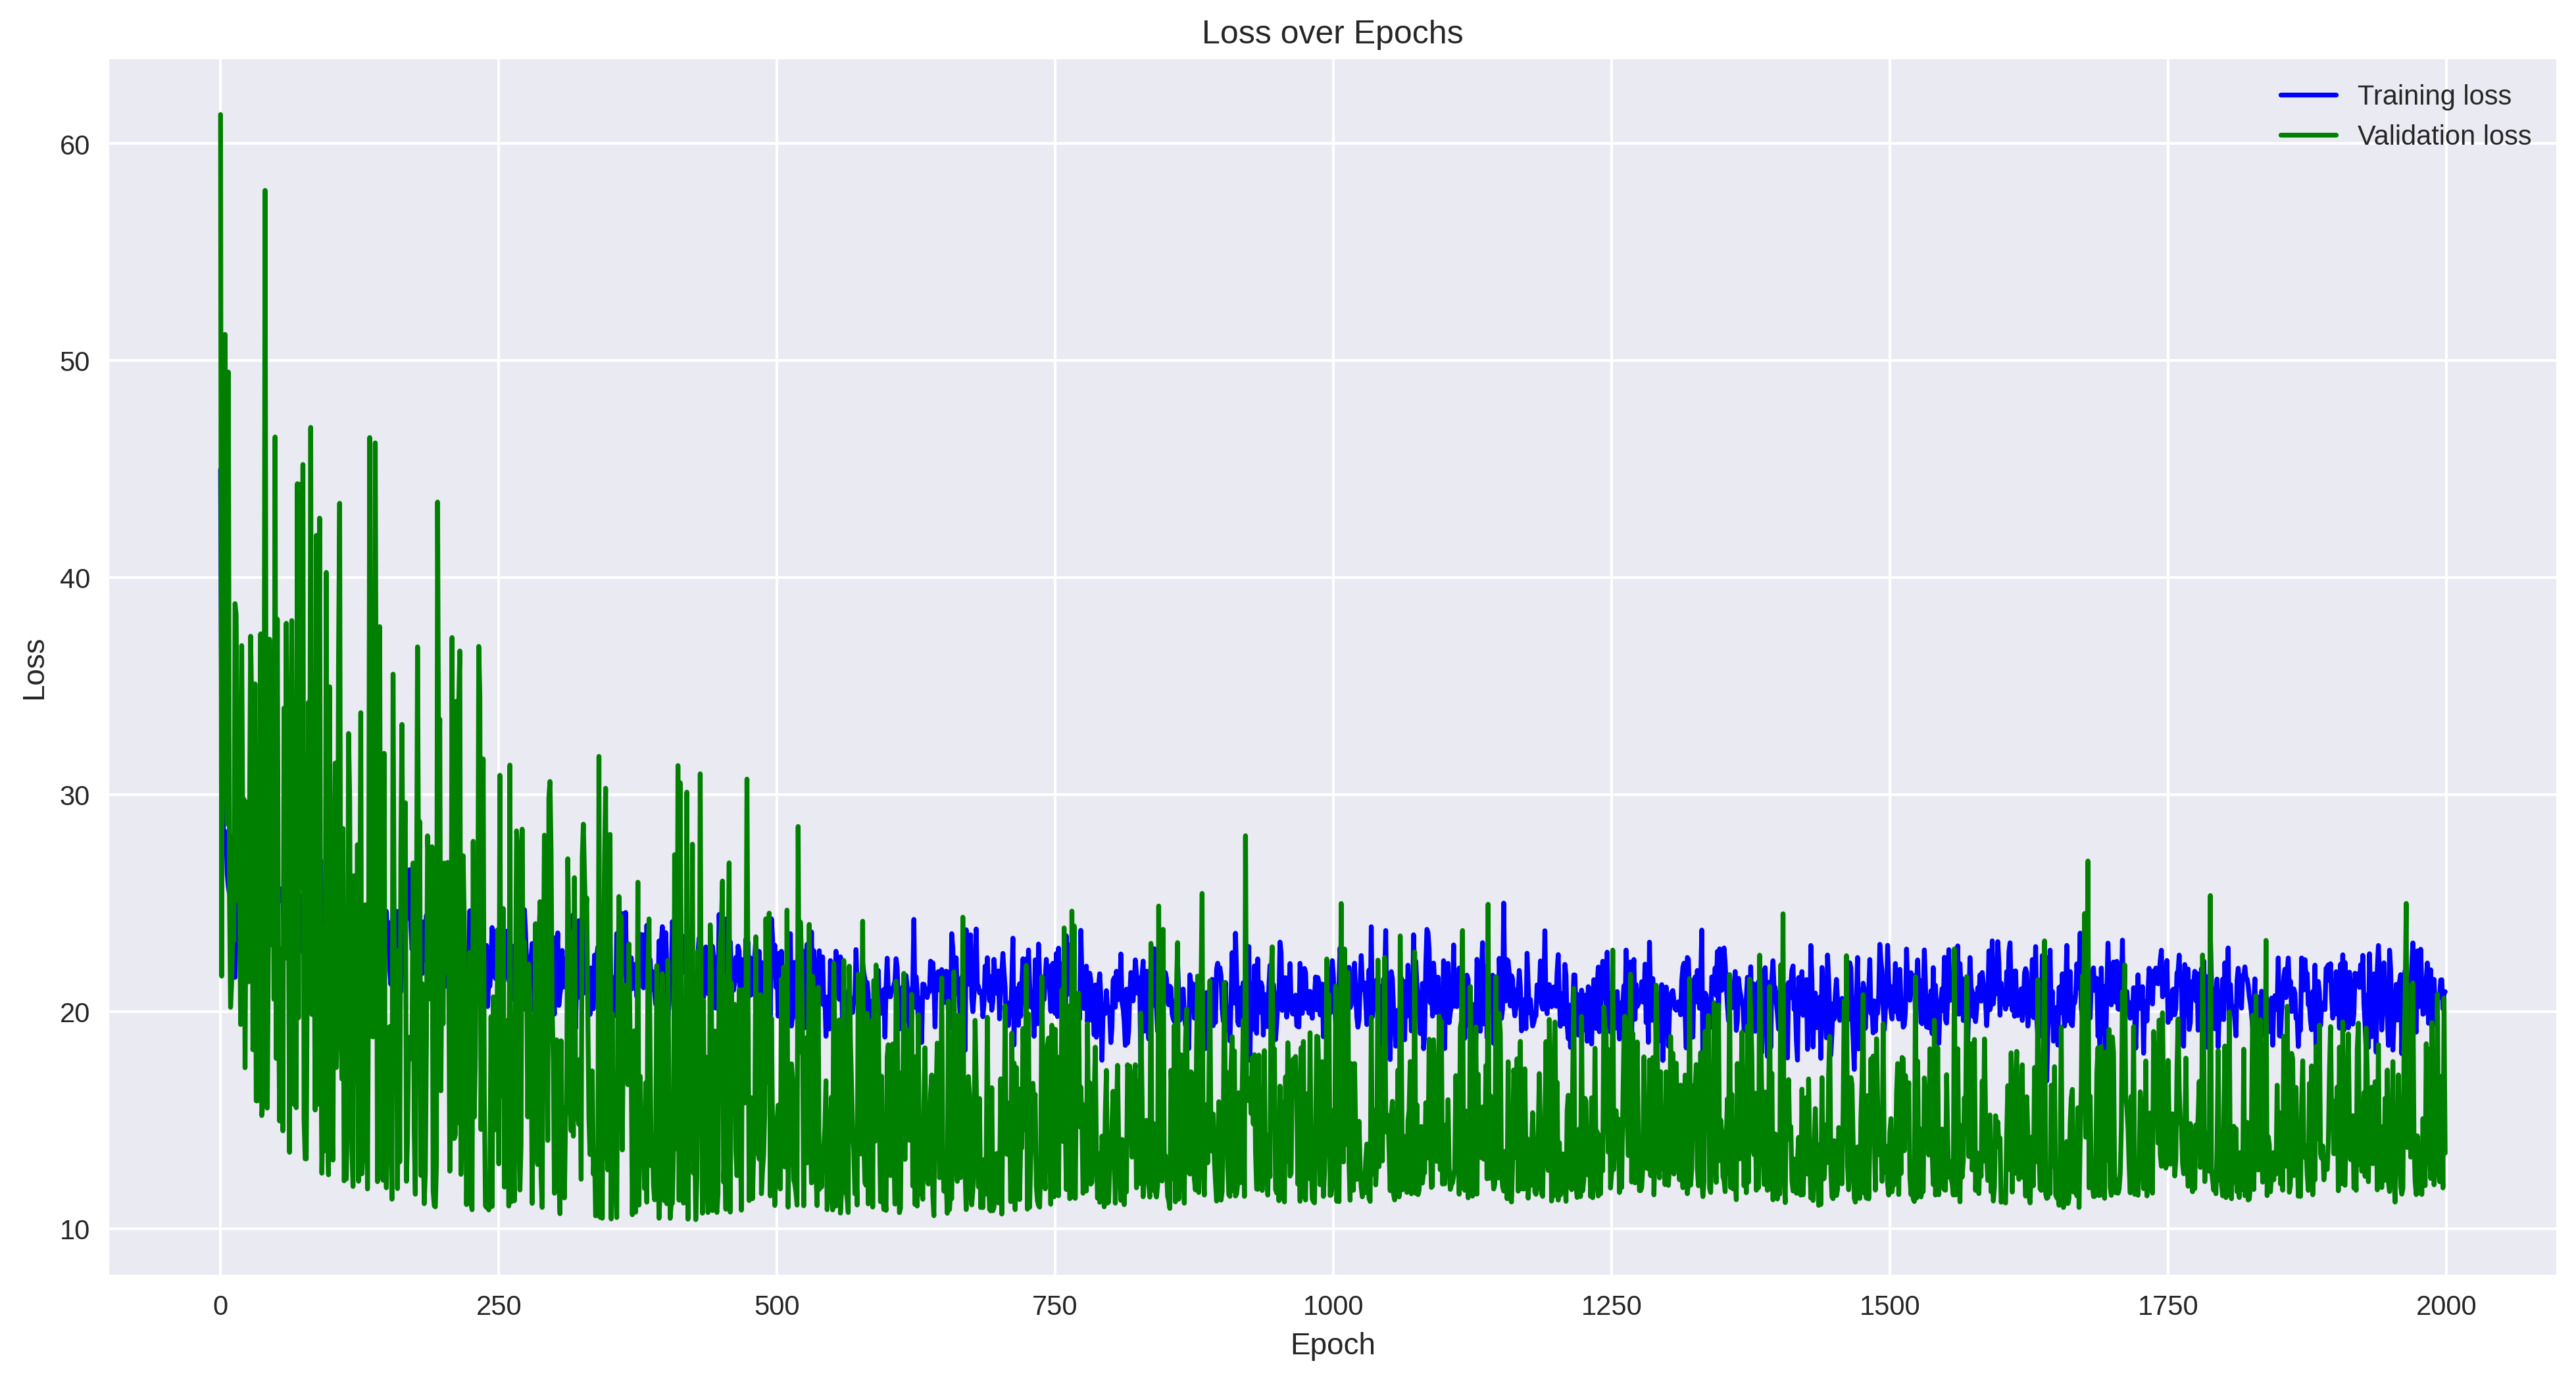

In [27]:
train_losses = np.array(train_losses)
valid_losses = np.array(valid_losses)
fig, ax = plt.subplots()
ax.plot(train_losses, color='blue', label='Training loss')
ax.plot(valid_losses, color='green', label='Validation loss')
ax.set(title="Loss over Epochs", xlabel='Epoch', ylabel='Loss')
ax.legend()
plt.show()

- The graph shows the losses lines are erratic, the reasons are as follows:
  - dataset is small
  - insufficient regularization
  - the batch size is too small

In [28]:
y_pred, y_valid = [], []
with torch.no_grad():
  CNN.eval()
  for x_val, y_val in valid_loader:
    x_val = x_val.to(device)
    x_val = x_val.view(x_val.shape[0], 1, n_lags)
    y_pred.append(CNN(x_val))
    y_valid.append(y_val)
        
y_pred = torch.cat(y_pred).numpy().flatten()
y_valid = torch.cat(y_valid).numpy().flatten()

CNN Forecast - MSE: 187.56, RMSE: 13.70


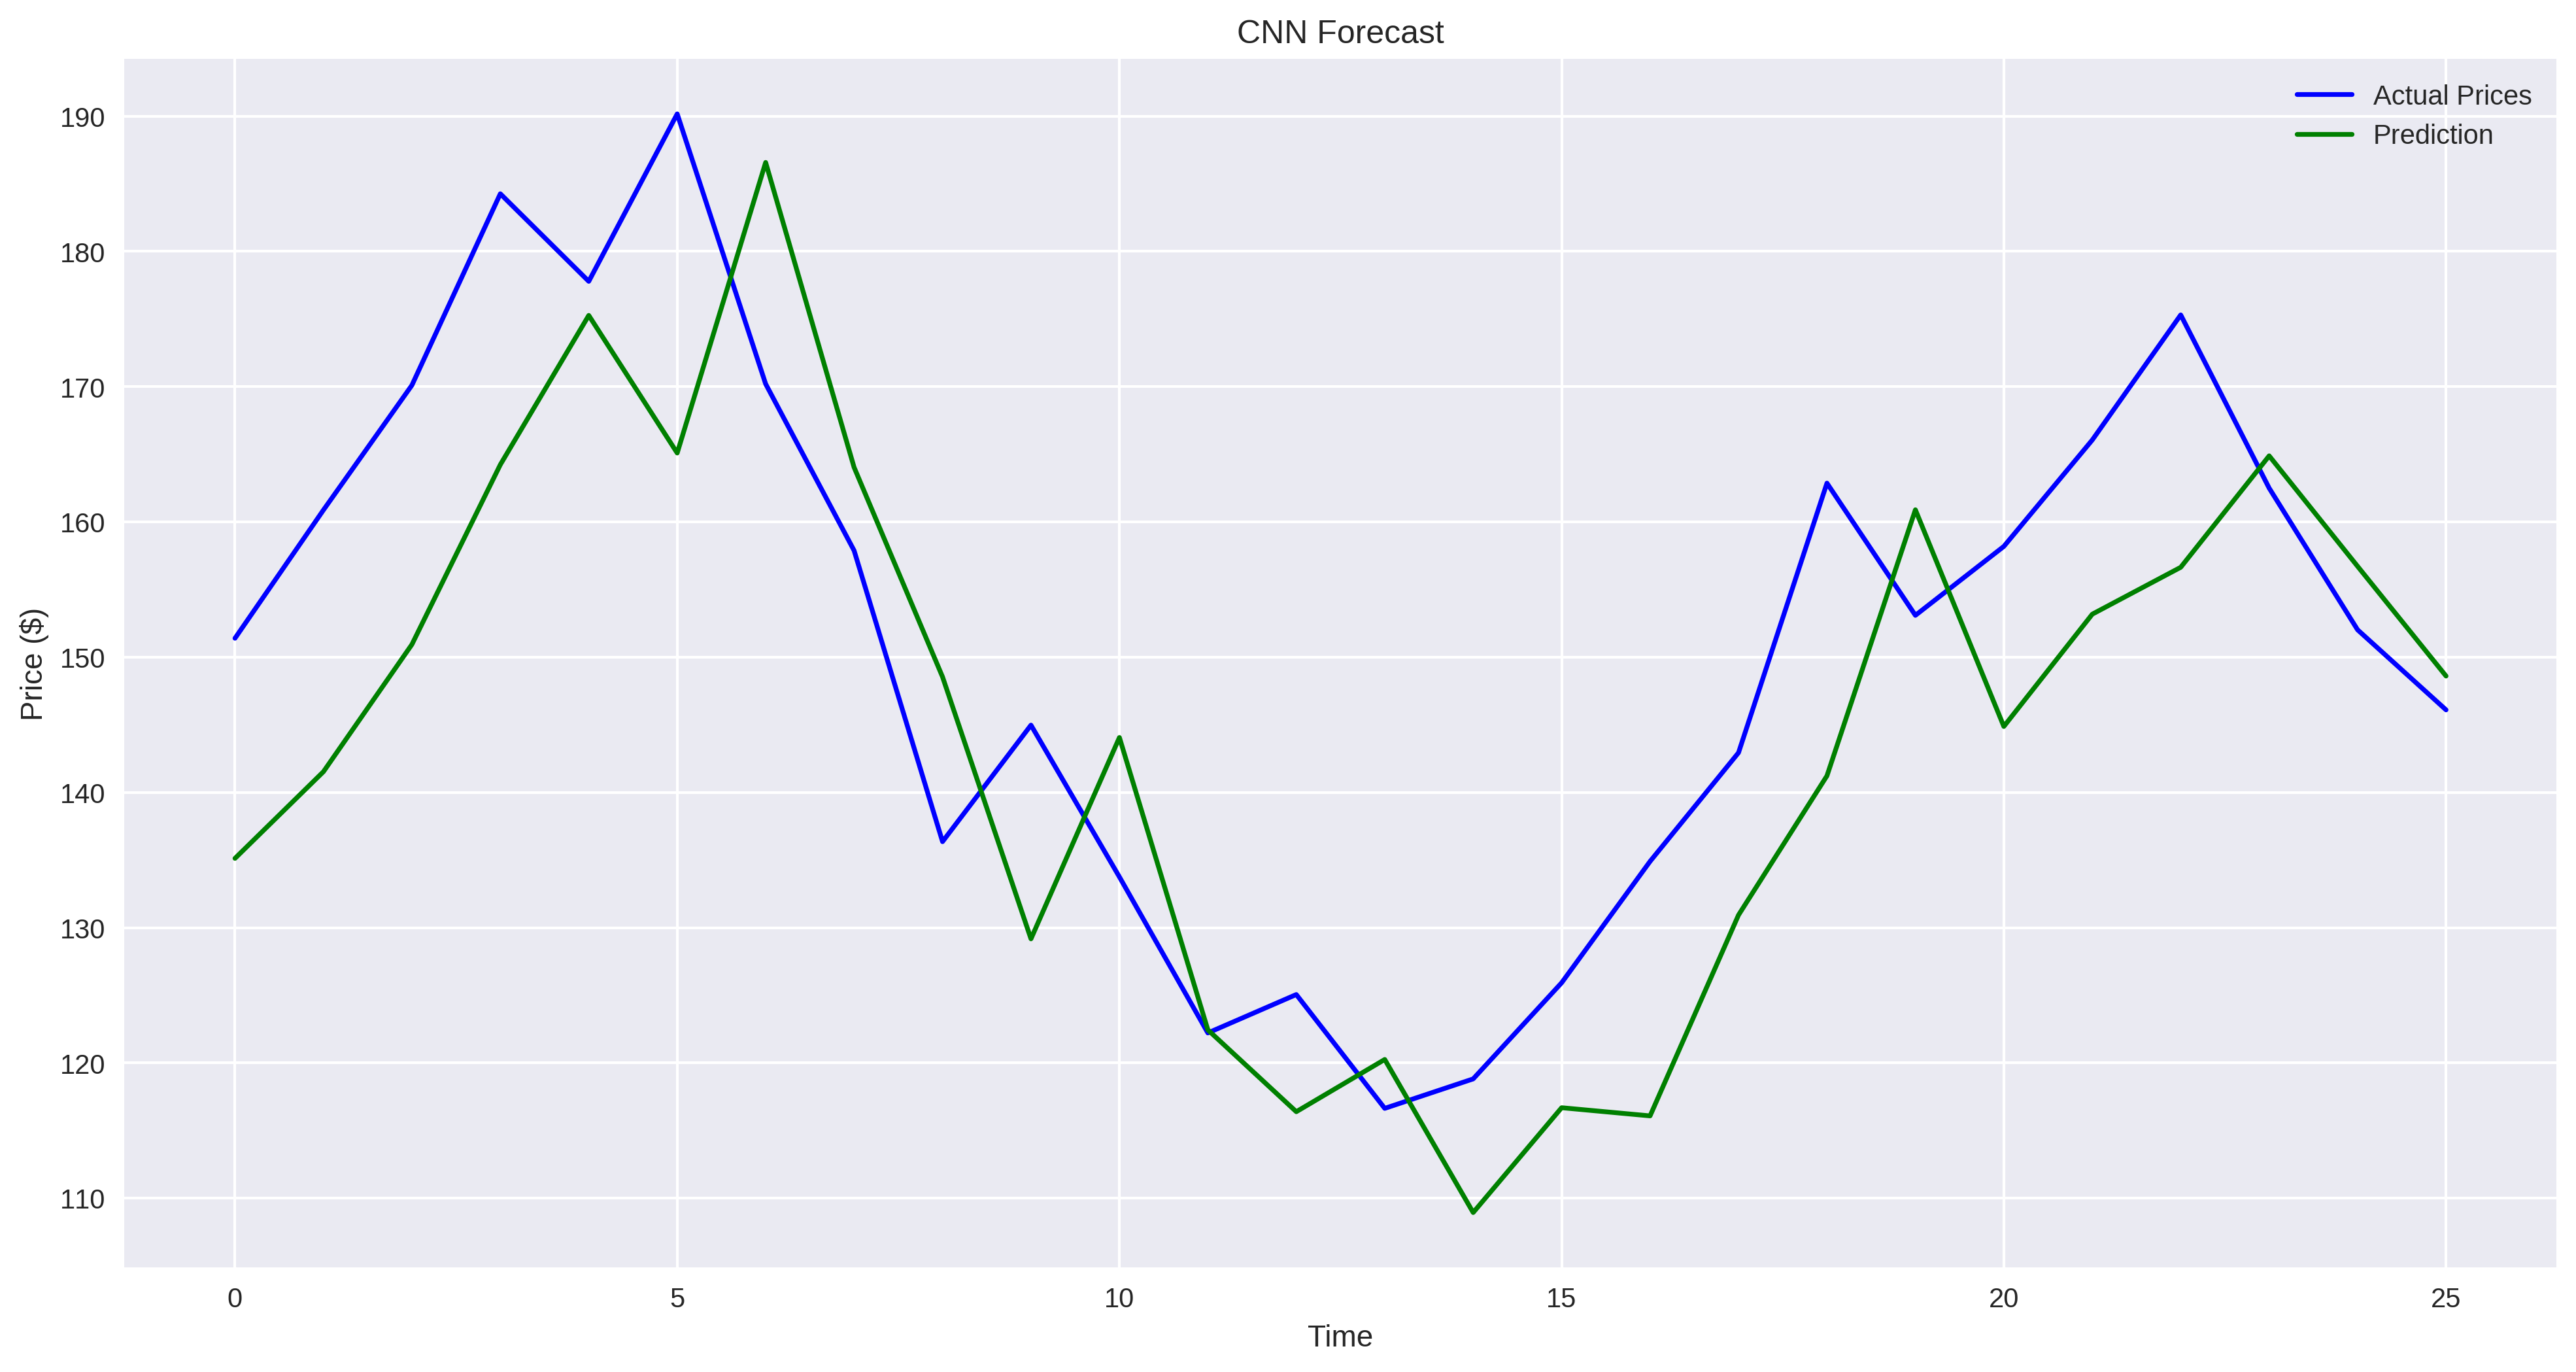

In [29]:
cnn_mse = mean_squared_error(y_valid, y_pred)
cnn_rmse = np.sqrt(cnn_mse)
print(f"CNN Forecast - MSE: {cnn_mse:.2f}, RMSE: {cnn_rmse:.2f}")

fig, ax = plt.subplots()
ax.plot(y_valid, color='blue', label='Actual Prices')
ax.plot(y_pred, color='green', label='Prediction')
ax.set(title="CNN Forecast", xlabel='Time', ylabel='Price ($)')
ax.legend()
plt.show()

## RNN for Time Series Forecasting

- Extensional models of RNN: LSTM, GRU(Gated Recurrent Unit), Bidirectional RNN
  
### Architecture:
- Do not take all input data at once, it input dataset sequentially, gaining outputs(hidden state)
  - hidden state, also called *memory*, owing to contain the context of the past inputs of the sequence
- The hidden state + next input → the following output.
- Weights/Parameters are shared for all steps of RNN
- `ReLU` activation function is recommended, rather than using tanh or sigmoid
- Training period uses **Back-propagation Through Time algorithm**, whose gradient errors of each step depends on previous steps
- Mapping types and related tasks
  - 1-1: binary image classification
  - 1-n: creating image caption
  - n-1: the sentence sentiment classification
  - n-n: machine translation

In [30]:
from sklearn.preprocessing import MinMaxScaler

In [31]:
#define parameters
batch_size=16
n_epochs=100
n_lags=12

In [32]:
prices = NVDA['Adj Close'].values.reshape(-1, 1)

In [34]:
#rescale the prices time series
minmax = MinMaxScaler(feature_range=(0, 1))
valid_index = len(prices) - valid_size
prices_train = prices[:valid_index]
prices_valid = prices[valid_index:]
minmax.fit(prices_train) #fit scaler with training data
#transform both
prices_train = minmax.transform(prices_train)
prices_valid = minmax.transform(prices_valid)
prices_scaled = np.concatenate((prices_train, prices_valid)).flatten()

In [35]:
X, y = create_input_data(prices_scaled, n_lags)

In [36]:
#make naive prediction with unscaled data
naive_pred = prices[len(prices)-valid_size-1:-1]
y_valid = prices[len(prices)-valid_size:]
naive_mse = mean_squared_error(y_valid, naive_pred)
naive_rmse = np.sqrt(naive_mse)
print(f"Naive Forecast – MSE: {naive_mse:.4f}, RMSE: {naive_rmse:.4f}")

Naive Forecast – MSE: 123.5026, RMSE: 11.1132


In [37]:
#prepare a dataloader for batch generation convenience
custom_set_seed(42)
X_tensor = torch.from_numpy(X).float().reshape(X.shape[0],X.shape[1], 1) #[number of observations, length of the series, number of features]
y_tensor = torch.from_numpy(y).float().reshape(X.shape[0], 1)
dataset = TensorDataset(X_tensor, y_tensor)
valid_index = len(X) - valid_size
train_dataset = Subset(dataset, list(range(valid_index)))
valid_dataset = Subset(dataset, list(range(valid_index, len(X))))
train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size, shuffle=True) #shuffle is allowed: the sequence order we want to learn is already captured within the lagged features.
valid_loader = DataLoader(dataset=valid_dataset,  batch_size=batch_size)

In [43]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, n_layers, output_size):
    '''
    input_size: expected number of features
    hidden_size: numbers of neurons in hidden state
    n_layers: number of RNN layers stacked on top of one another, be default we set=1
    output_size: The size of the output; for the many-to-one case, we set =1
    '''
    super(RNN, self).__init__()
    self.rnn = nn.RNN(input_size, 
                      hidden_size, 
                      n_layers, 
                      batch_first=True,  #the first argument of the input is batch size
                      nonlinearity='relu') 
    self.fc = nn.Linear(hidden_size, output_size)
    
  def forward(self, x):
    output, _ = self.rnn(x)
    output = self.fc(output[:,-1,:])  #pass the output to fully connected layer
    return output

In [44]:
#set model parameters, loss function, and optimizer
RNN = RNN(input_size=1, 
          hidden_size=6, 
          n_layers=1, 
          output_size=1).to(device)
loss_function = nn.MSELoss()
optimizer = optim.AdamW(RNN.parameters(), lr=0.001)

In [45]:
PRINT_EVERY = 10
train_losses, valid_losses = [], []

for epoch in range(n_epochs):
  running_loss_train = 0
  running_loss_valid = 0

  RNN.train()
    
  for x_batch, y_batch in train_loader:
    optimizer.zero_grad()
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    y_hat = RNN(x_batch)
    loss = torch.sqrt(loss_function(y_batch, y_hat))
    loss.backward()
    optimizer.step()
    running_loss_train += loss.item() * x_batch.size(0)
  epoch_loss_train = running_loss_train / len(train_loader.dataset)
  train_losses.append(epoch_loss_train)

  with torch.no_grad():
    RNN.eval()
    for x_val, y_val in valid_loader:
      x_val = x_val.to(device)
      y_val = y_val.to(device)
      y_hat = RNN(x_val)
      loss = torch.sqrt(loss_function(y_val, y_hat))
      running_loss_valid += loss.item() * x_val.size(0)
            
    epoch_loss_valid = running_loss_valid / len(valid_loader.dataset)
            
    if epoch > 0 and epoch_loss_valid < min(valid_losses):
      best_epoch = epoch
      torch.save(RNN.state_dict(), './rnn.pth')
            
    valid_losses.append(epoch_loss_valid)

  if epoch % PRINT_EVERY == 0:
    print(f"<{epoch}> – Train. loss: {epoch_loss_train:.4f} \t Valid. loss: {epoch_loss_valid:.4f}")
print(f'Lowest loss recorded in epoch: {best_epoch}')

<0> – Train. loss: 0.4679 	 Valid. loss: 0.5118
<10> – Train. loss: 0.2718 	 Valid. loss: 0.2419
<20> – Train. loss: 0.2189 	 Valid. loss: 0.1142
<30> – Train. loss: 0.2041 	 Valid. loss: 0.1049
<40> – Train. loss: 0.1837 	 Valid. loss: 0.0885
<50> – Train. loss: 0.1498 	 Valid. loss: 0.0692
<60> – Train. loss: 0.0900 	 Valid. loss: 0.0469
<70> – Train. loss: 0.0358 	 Valid. loss: 0.0403
<80> – Train. loss: 0.0360 	 Valid. loss: 0.0400
<90> – Train. loss: 0.0360 	 Valid. loss: 0.0399
Lowest loss recorded in epoch: 66


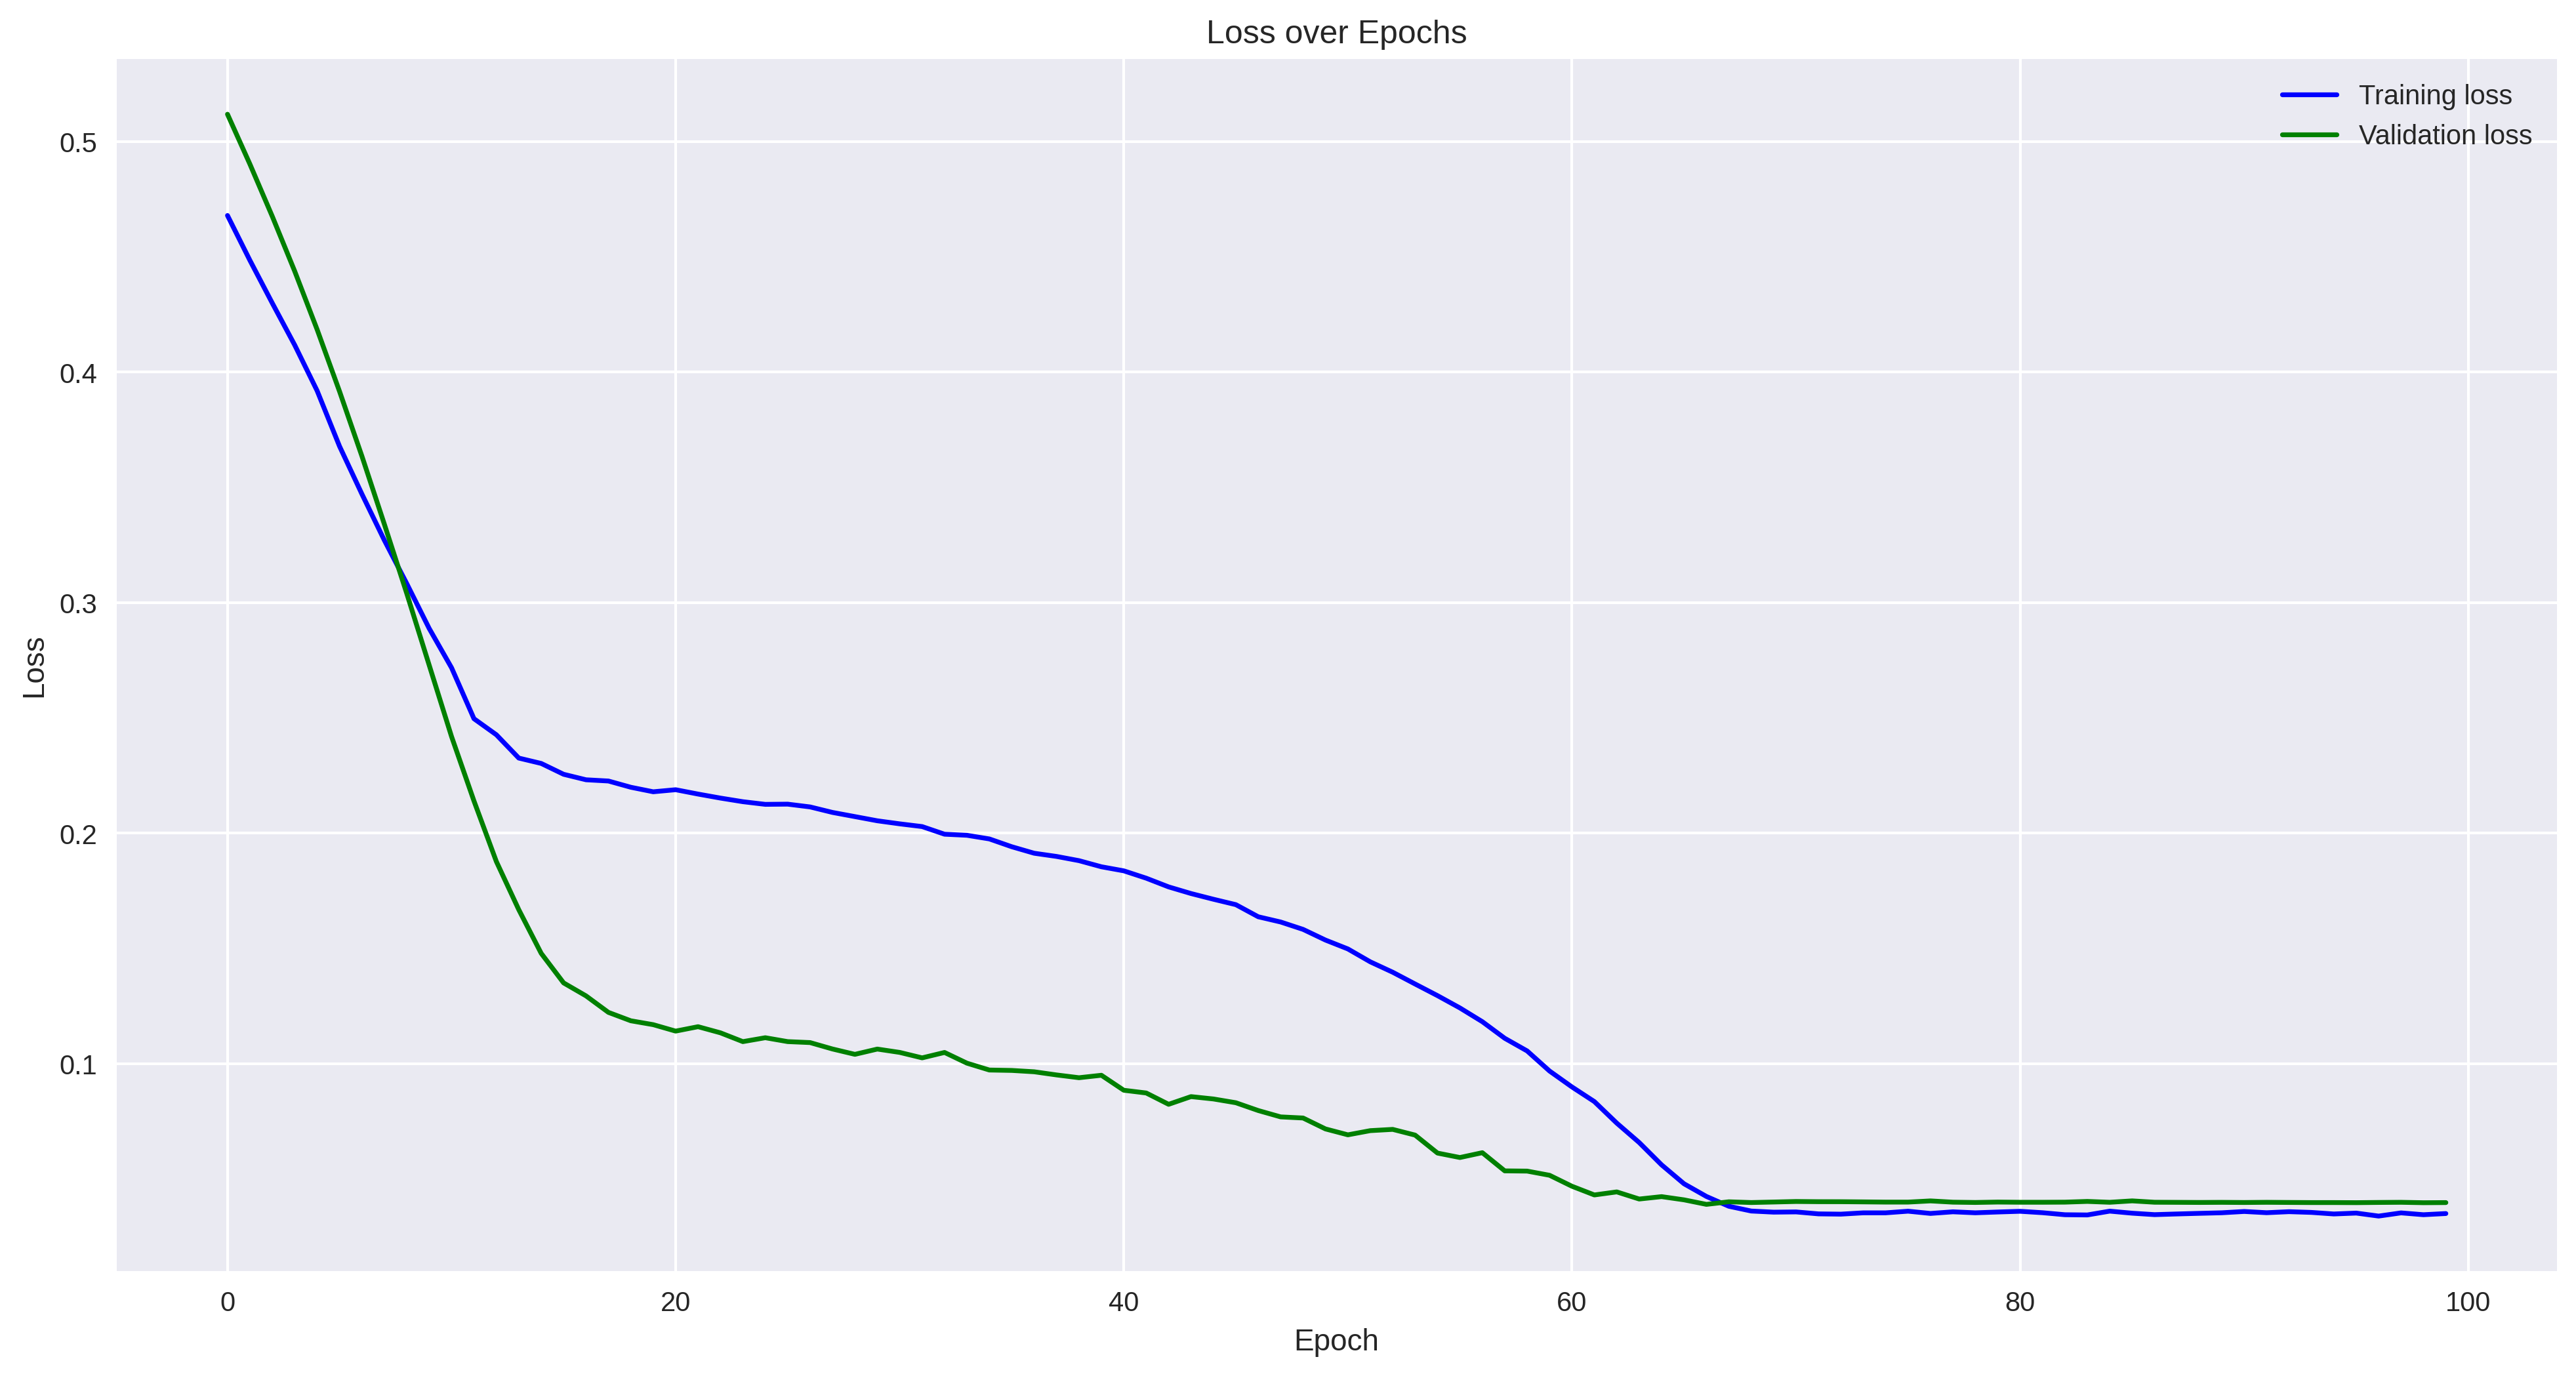

In [46]:
train_losses = np.array(train_losses)
valid_losses = np.array(valid_losses)
fig, ax = plt.subplots()
ax.plot(train_losses, color='blue', label='Training loss')
ax.plot(valid_losses, color='green', label='Validation loss')
ax.set(title="Loss over Epochs", xlabel='Epoch', ylabel='Loss')
ax.legend()
plt.show()

In [48]:
#make predication based on validation set and performance evaluation
y_pred = []
with torch.no_grad():
  RNN.eval()
    
  for x_val, y_val in valid_loader:
    x_val = x_val.to(device)
    y_hat = RNN(x_val)
    y_pred.append(y_hat)
y_pred = torch.cat(y_pred).numpy()
y_pred = minmax.inverse_transform(y_pred).flatten() #convert back to original scale

RNN Forecast - MSE: 144.59, RMSE: 13.70


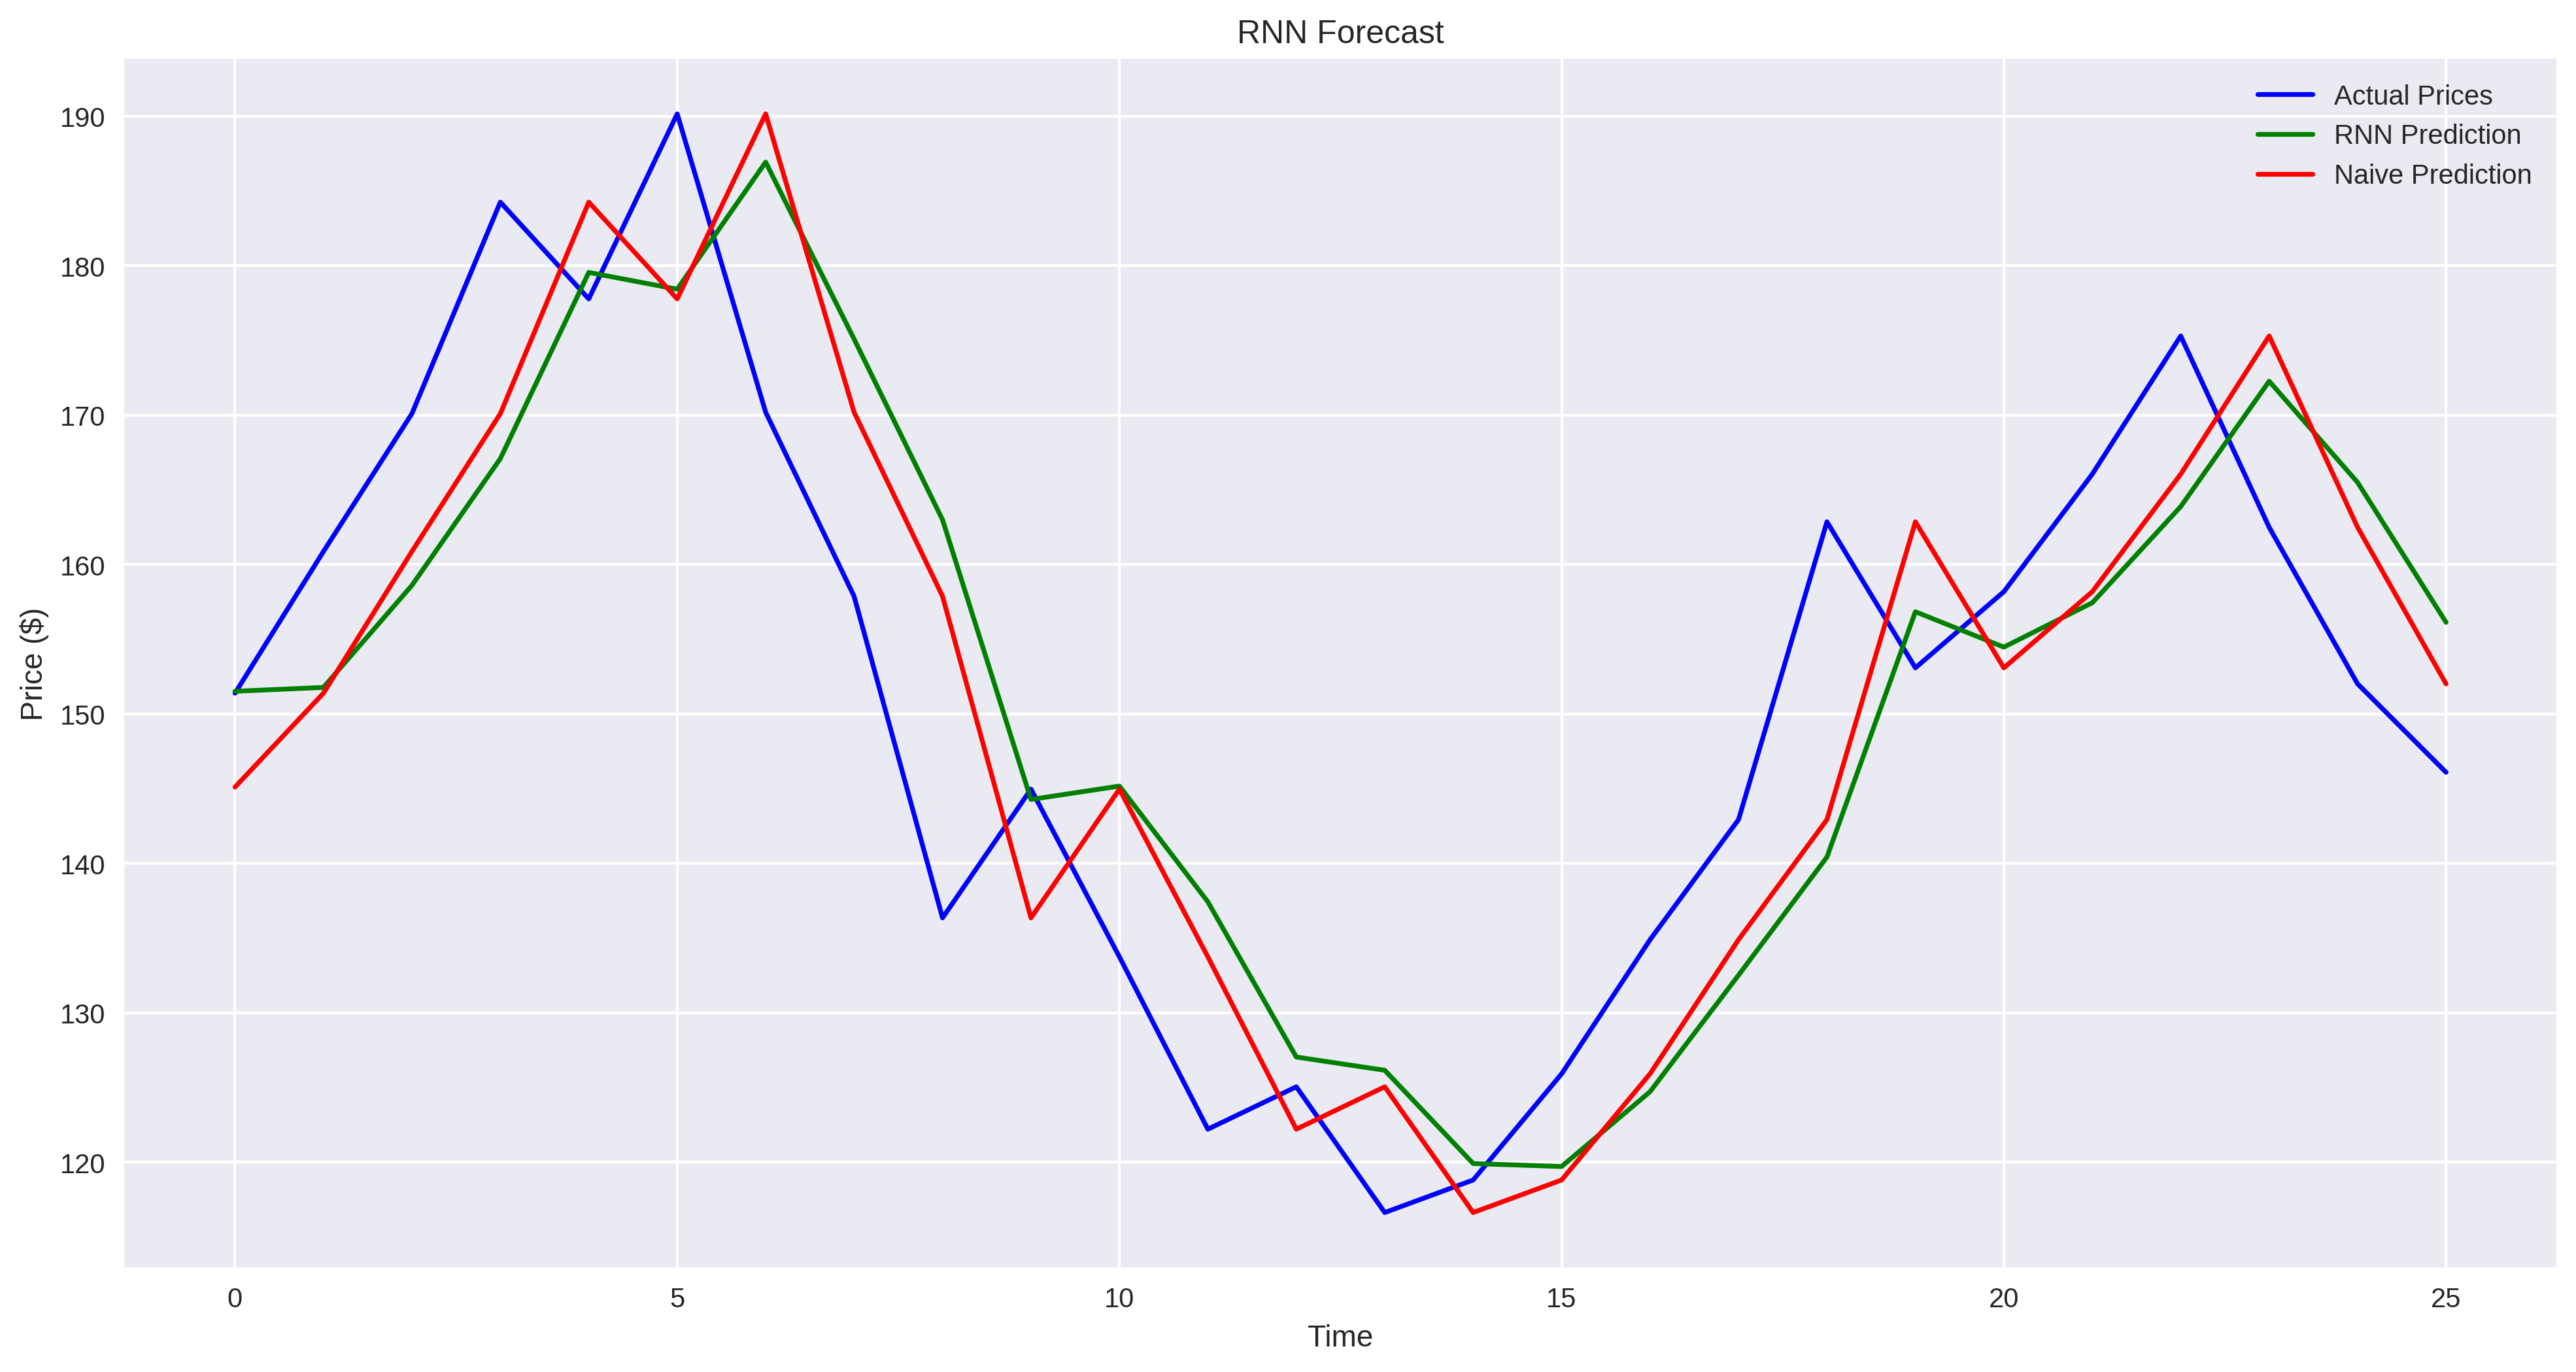

In [50]:
rnn_mse = mean_squared_error(y_valid, y_pred)
rnn_rmse = np.sqrt(cnn_mse)
print(f"RNN Forecast - MSE: {rnn_mse:.2f}, RMSE: {rnn_rmse:.2f}")
fig, ax = plt.subplots()
ax.plot(y_valid, color='blue', label='Actual Prices')
ax.plot(y_pred, color='green', label='RNN Prediction')
ax.plot(naive_pred, color='red', label='Naive Prediction')
ax.set(title="RNN Forecast", xlabel='Time', ylabel='Price ($)')
ax.legend()
plt.show()